In [1]:
import os, sys

if "adroit" in os.uname()[1]:
    CUSTOM_MODULE_PATH = "/home/jylin/thesis/modules"
else:
    CUSTOM_MODULE_PATH = "/System/Volumes/Data/Users/jesselin/Dropbox/src/thesis/modules"
sys.path.append(CUSTOM_MODULE_PATH)
# custom imports
from modules.entropy import get_entropy
from modules.my_funcs import *

# scientific libraries
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
import networkx as nx

# other imports
import pickle
from tqdm import tqdm, trange
import glob


ModuleNotFoundError: No module named 'modules'

In [2]:
# jupyter libraries
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
plt.rcParams["font.size"] = "14"
plt.rcParams["figure.dpi"] = "120"

In [5]:
INTERACTION_Kc = np.log(1+ np.sqrt(2))/2

In [6]:
RES_DIR = "/Users/jesselin/Dropbox/src/thesis/final/resources"
DATA_DIR = "/Users/jesselin/Dropbox/src/thesis/final/data"

In [7]:
FIG_DIR = "/Users/jesselin/Dropbox/Working/Thesis/paper/images"

# Figure Functions

In [12]:
def spin_history(spindata, reduced_hdata, length=999):
    cmap = mpl.cm.get_cmap(name="tab10")
    fig = plt.figure()
    fig.set_size_inches(6,4)
    fig.set_dpi(300)
    ax = fig.add_subplot(111)
    xdata = np.arange(length)
    ax.plot(spindata, c=cmap.colors[0], linewidth=1, label=r"$\sigma_t$")
    ax.scatter(x=xdata, y=reduced_hdata, c=cmap.colors[1], s=3, label=r"$J \cdot h_t$")
    ax.legend(loc=(1.04,0.4))
    ax.set_xlim([0,100])
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$\sigma_t,$ $J \cdot h_t$")
    ax.set_title("Longer interactions induce more RNN states.")
    return plt.gcf()

In [13]:
def spin_dynamics_histogram(spindata, reduced_hdata, bins=50, length=999):
    cmap = mpl.cm.get_cmap(name="tab10")
    fig = plt.figure()
    fig.set_size_inches(6,4)
    fig.set_dpi(300)
    ax = fig.add_subplot(111)
    xdata = np.arange(length)
    hist_spindata = plt.hist(spindata, bins=bins, density=True, color=cmap.colors[0], label=r"$\sigma$")
    hist_hdata = plt.hist(reduced_hdata, bins=bins, density=True, color=cmap.colors[1], label=r"$J \cdot h$")
    ax.legend(loc=(1.04,0.4))

    plt.title(r"Probability density shows 4 state model$")
    plt.xlabel(r"$h(t),\sigma(t)$")
    plt.ylabel(r"$\rho$")
    plt.yscale("log")
    return plt.gcf(), hist_spindata, hist_hdata

In [14]:
def get_hdata(model, dataset, num_samples):
    spin_sequence_list = []
    standard_hidden_sequence_list = []
    whh = model.rnn.weight_hh_l0
    iterable_dataset = iter(dataset)
    for sample in trange(num_samples):
        spin_sequence, _ = next(iterable_dataset)
        numpy_spin_sequence = spin_sequence.detach().squeeze().numpy()
        spin_sequence_list.append(numpy_spin_sequence)
        hidden_sequence = model.record_hidden(spin_sequence)
        standard_hidden_sequence = torch.matmul(whh, hidden_sequence.unsqueeze(-1)).detach().squeeze().numpy()
        standard_hidden_sequence_list.append(standard_hidden_sequence)

    return spin_sequence_list, standard_hidden_sequence_list

In [15]:
def get_interaction_K_dir(resource_filepath):
    basename = os.path.basename(resource_filepath)
    interaction_K_str = basename[basename.index("K=")+2:]
    interaction_K_str = interaction_K_str.strip("[]").replace(",","").split(" ")
    interaction_K = [float(s) for s in interaction_K_str if s != ""]
    return interaction_K

def get_kfrac(log_dir):
    basename = os.path.basename(log_dir)
    idx = basename.index("kfrac=") + len("kfrac=")
    return basename[idx:]

In [16]:
def make_dataloader(dataset: SpinSequenceDataset, num_samples: int, batch_size: int = 10, num_workers: int = 0):
    """ Takes dataset and returns the DataLoader object """
    div, mod = divmod(len(dataset), num_samples)

    # make list of the split proportions
    split_list = [num_samples for x in range(div)]
    split_list.append(mod)

    dataset_after_split = random_split(dataset, split_list)
    train_loader = DataLoader(dataset_after_split[0], batch_size=batch_size, shuffle=True, num_workers=num_workers)

    return train_loader


# 1D SR

First, the training loss.

In [9]:
data_dir = "/Users/jesselin/Dropbox/src/thesis/final/data/1D/SR/macbook_K=1"

loss_list = []
for hs in np.arange(10)+1:
    ckpt_dir = os.path.join(data_dir, f"hidden_size={hs}/version_0/checkpoints")
    ckpt, = os.listdir(ckpt_dir)
    ckpt_filepath = os.path.join(ckpt_dir, ckpt)

    model = IsingRNN_simple.load_from_checkpoint(ckpt_filepath)
    loss_list.append(model.loss_history)


In [ ]:
entropy = get_entropy(1, [1,0,0])

cmap = mpl.cm.get_cmap(name="viridis", lut=10)
fig = plt.figure()
fig.set_size_inches(6,4)
fig.set_dpi(300)
ax = fig.add_subplot(111)
for i, l in enumerate(loss_list):
    ax.plot(l, color=cmap.colors[i], label=f"D={i+1}", linewidth=1)
ax.axhline(y=entropy, color="k", linestyle="--", linewidth=1.2)
ax.set_xlabel("Training Iterations")
ax.set_ylabel("Loss")
ax.set_xscale("log")
ax.text(1, entropy*1.03, r"Ising model entropy")
ax.legend(loc=(1.04,0))
ax.set_title(r"RNN learns the $d=1$ NN Ising model")

Next, the correlation function.

In [118]:
with open("cf_K=1.pickle", "rb") as f:
    a = pickle.load(f)

In [122]:
cf_m, cf_e = a
xdata = np.arange(2048)

In [132]:
def exact_NN_corrfunc(x, interaction_K):
    corr_length = 1/(np.log(1/np.tanh(interaction_K)))
    return np.exp(-x/corr_length)

In [ ]:
cmap = mpl.cm.get_cmap(name="viridis", lut=10)
fig = plt.figure()
fig.set_size_inches(6,4)
fig.set_dpi(300)
ax = fig.add_subplot(111)
ax.errorbar(xdata, cf_m, yerr=cf_e, linestyle="none", marker=".", markersize=3)
ax.plot(exact_NN_corrfunc(xdata, 1))

#ax.plot(l, color=cmap.colors[i], label=f"D={i}", linewidth=1)
ax.set_xlim([-5,100])
ax.set_xlabel("t")
ax.set_ylabel("C(t)")
#ax.legend(loc=(1.04,0))
ax.set_title(r"RNN-generated correlations vs. exact $C(t)$")

Now, the spin history.

In [232]:
res_path = "/Users/jesselin/Dropbox/src/thesis/final/resources/1D/SR/trainData_K=1.npz"
dataset = SpinSequenceDataset(res_path, 1)

In [233]:
hs = 1
ckpt_dir = os.path.join(data_dir, f"hidden_size={hs}/version_0/checkpoints")
ckpt, = os.listdir(ckpt_dir)
ckpt_filepath = os.path.join(ckpt_dir, ckpt)

model = IsingRNN_simple.load_from_checkpoint(ckpt_filepath)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/jesselin/Dropbox/src/thesis/final/data/2D/hidden_size=1/version_0/checkpoints'

In [ ]:
s, h = get_hdata(model, dataset, num_samples=1)
spindata, hdata = s[0], h[0]

In [ ]:
cmap = mpl.cm.get_cmap(name="tab10")
fig = plt.figure()
fig.set_size_inches(6,4)
fig.set_dpi(300)
ax = fig.add_subplot(111)
xdata = np.arange(999)
ax.plot(spindata, c=cmap.colors[0], linewidth=1, label=r"$\sigma_t$")
ax.scatter(x=xdata, y=hdata, c=cmap.colors[1], s=3, label=r"$J \cdot h_t$")
ax.legend(loc=(1.04,0.4))
ax.set_xlim([0,100])
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\sigma_t,$ $J \cdot h_t$")
ax.set_title("RNN learns to memorize the previous spin")

In [47]:
1/(model.rnn.weight_hh_l0/model.rnn.weight_ih_l0)

tensor([[-5.5794]], grad_fn=<MulBackward0>)

# 1D LR

## Big loss figure

In [124]:
res_dir = "/Users/jesselin/Dropbox/src/thesis/final/data/1D/LR"
search_term = "adroit*"
fl = glob.glob(os.path.join(res_dir, search_term))

result_dict = {}
for f in tqdm(fl):
    interaction_K = get_interaction_K(f)
    if interaction_K == [1.0, 1.0, 1.0]:
        entropy = float(get_entropy(dimension=1, interaction_K=[1.0, 1.0, 0.95]))
    else:
        entropy = float(get_entropy(dimension=1, interaction_K=interaction_K))

    hlist = []
    for h in np.arange(5)+1:
        ckpt_dir = os.path.join(f,f"hidden_size={h}/version_0/checkpoints")
        ckpt, = os.listdir(ckpt_dir)
        ckpt_filepath = os.path.join(ckpt_dir, ckpt)
        model = IsingRNN_simple.load_from_checkpoint(ckpt_filepath)
        ydata = model.loss_history
        ydata = (ydata-entropy)/entropy
        hlist.append(ydata)

    result_dict[f] = hlist


100%|██████████| 66/66 [00:48<00:00,  1.35it/s]


In [ ]:
res_dir = "/Users/jesselin/Dropbox/src/thesis/final/data/1D/LR"
search_term = "adroit*"
fl = glob.glob(os.path.join(res_dir, search_term))
cmap = mpl.cm.get_cmap(name="viridis", lut=5)
fig = plt.figure()
fig.set_size_inches(6,4)
fig.set_dpi(300)
ax = fig.add_subplot(111)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([10e-3, 100])

random_bolds = sorted([np.random.randint(0,len(fl[:-1])) for x in range(5)])
for j, f in enumerate(fl[:-1]):
    interaction_K = get_interaction_K_dir(f)
    hlist = result_dict[f]
    for i, ydata in enumerate(hlist):
        if j in random_bolds:
            rand_idx_selected = random_bolds.index(j)
            if i == rand_idx_selected:
                print("bolding")
                alpha = 1
                linewidth = 1.2
                zorder = 3
                label = f"D={i+1}"
            else:
                alpha = 0.2
                linewidth = 0.5
                zorder = 1
                label = None
        else:
            alpha = 0.2
            linewidth = 0.5
            zorder = 1
            label = None
        ax.plot(ydata, color=cmap.colors[i-1], linewidth=linewidth, alpha=alpha, zorder=zorder, label=label)
ax.legend(loc=(1.04, 0.33))
ax.set_ylabel(r"$(\mathcal{L}-S)/S$")
ax.set_xlabel(r"Training Iterations")
ax.set_title(r"RNN learns with $1 \leq k \leq 3$.")

In [40]:
for i, f in enumerate(fl):
    interaction_K = get_interaction_K(f)
    if interaction_K == [1.0, 0.8, 0.7]:
        print(i)


In [224]:
def update_rule(h, th, j, hstates):
    j = j.detach().numpy()
    th = th.detach().numpy()
    transition_rules = {}
    for s in [-1, 1]:
        out_state = j*np.tanh(j*h + th*s)
        out_state = out_state.item()
        out_hstate = np.argmin(np.abs(out_state - np.array(hstates)))
        transition_rules[s] = (out_hstate, out_state)
    return transition_rules

def update_rule_2state(h1, th, j, hstates):
    initial_conds = np.array([[-1.,-1.], [-1., 1.], [1., -1.], [1.,1.]])
    j = j.detach().numpy()
    th = th.detach().numpy()
    transition_rules = {}
    for s2 in initial_conds:
        h2 = np.tanh(j*h1 + th*s2[0])
        h3 = np.tanh(j*h2 + th*s2[1])
        out_state = (j*h3).item()
        out_hstate = np.argmin(np.abs(out_state - np.array(hstates)))
        transition_rules[tuple(s2)] = (out_hstate, out_state)
    return transition_rules

In [53]:
dataset = SpinSequenceDataset("/Users/jesselin/Dropbox/src/thesis/final/resources/1D/LR/arr_sampledata_K=[1.  0.1].npz", interaction_K=[1, 0.1])
model = IsingRNN_simple.load_from_checkpoint(f"/Users/jesselin/Dropbox/src/thesis/final/data/1D/LR/macbook_K=[1.0, 0.1, 0.0]/hidden_size=1/version_4/checkpoints/epoch=3-step=399.ckpt")

In [54]:
spindata_arr, hdata_arr = get_hdata(model, dataset, 10)
spindata, hdata = spindata_arr[0], hdata_arr[0]
reduced_hdata = hdata

100%|██████████| 10/10 [00:00<00:00, 313.97it/s]


In [36]:
proj_data, evals, evecs = pca(hdata, pc_count=2)

Text(0.5, 1.0, '4-state discrete state space evident in $D=2$')

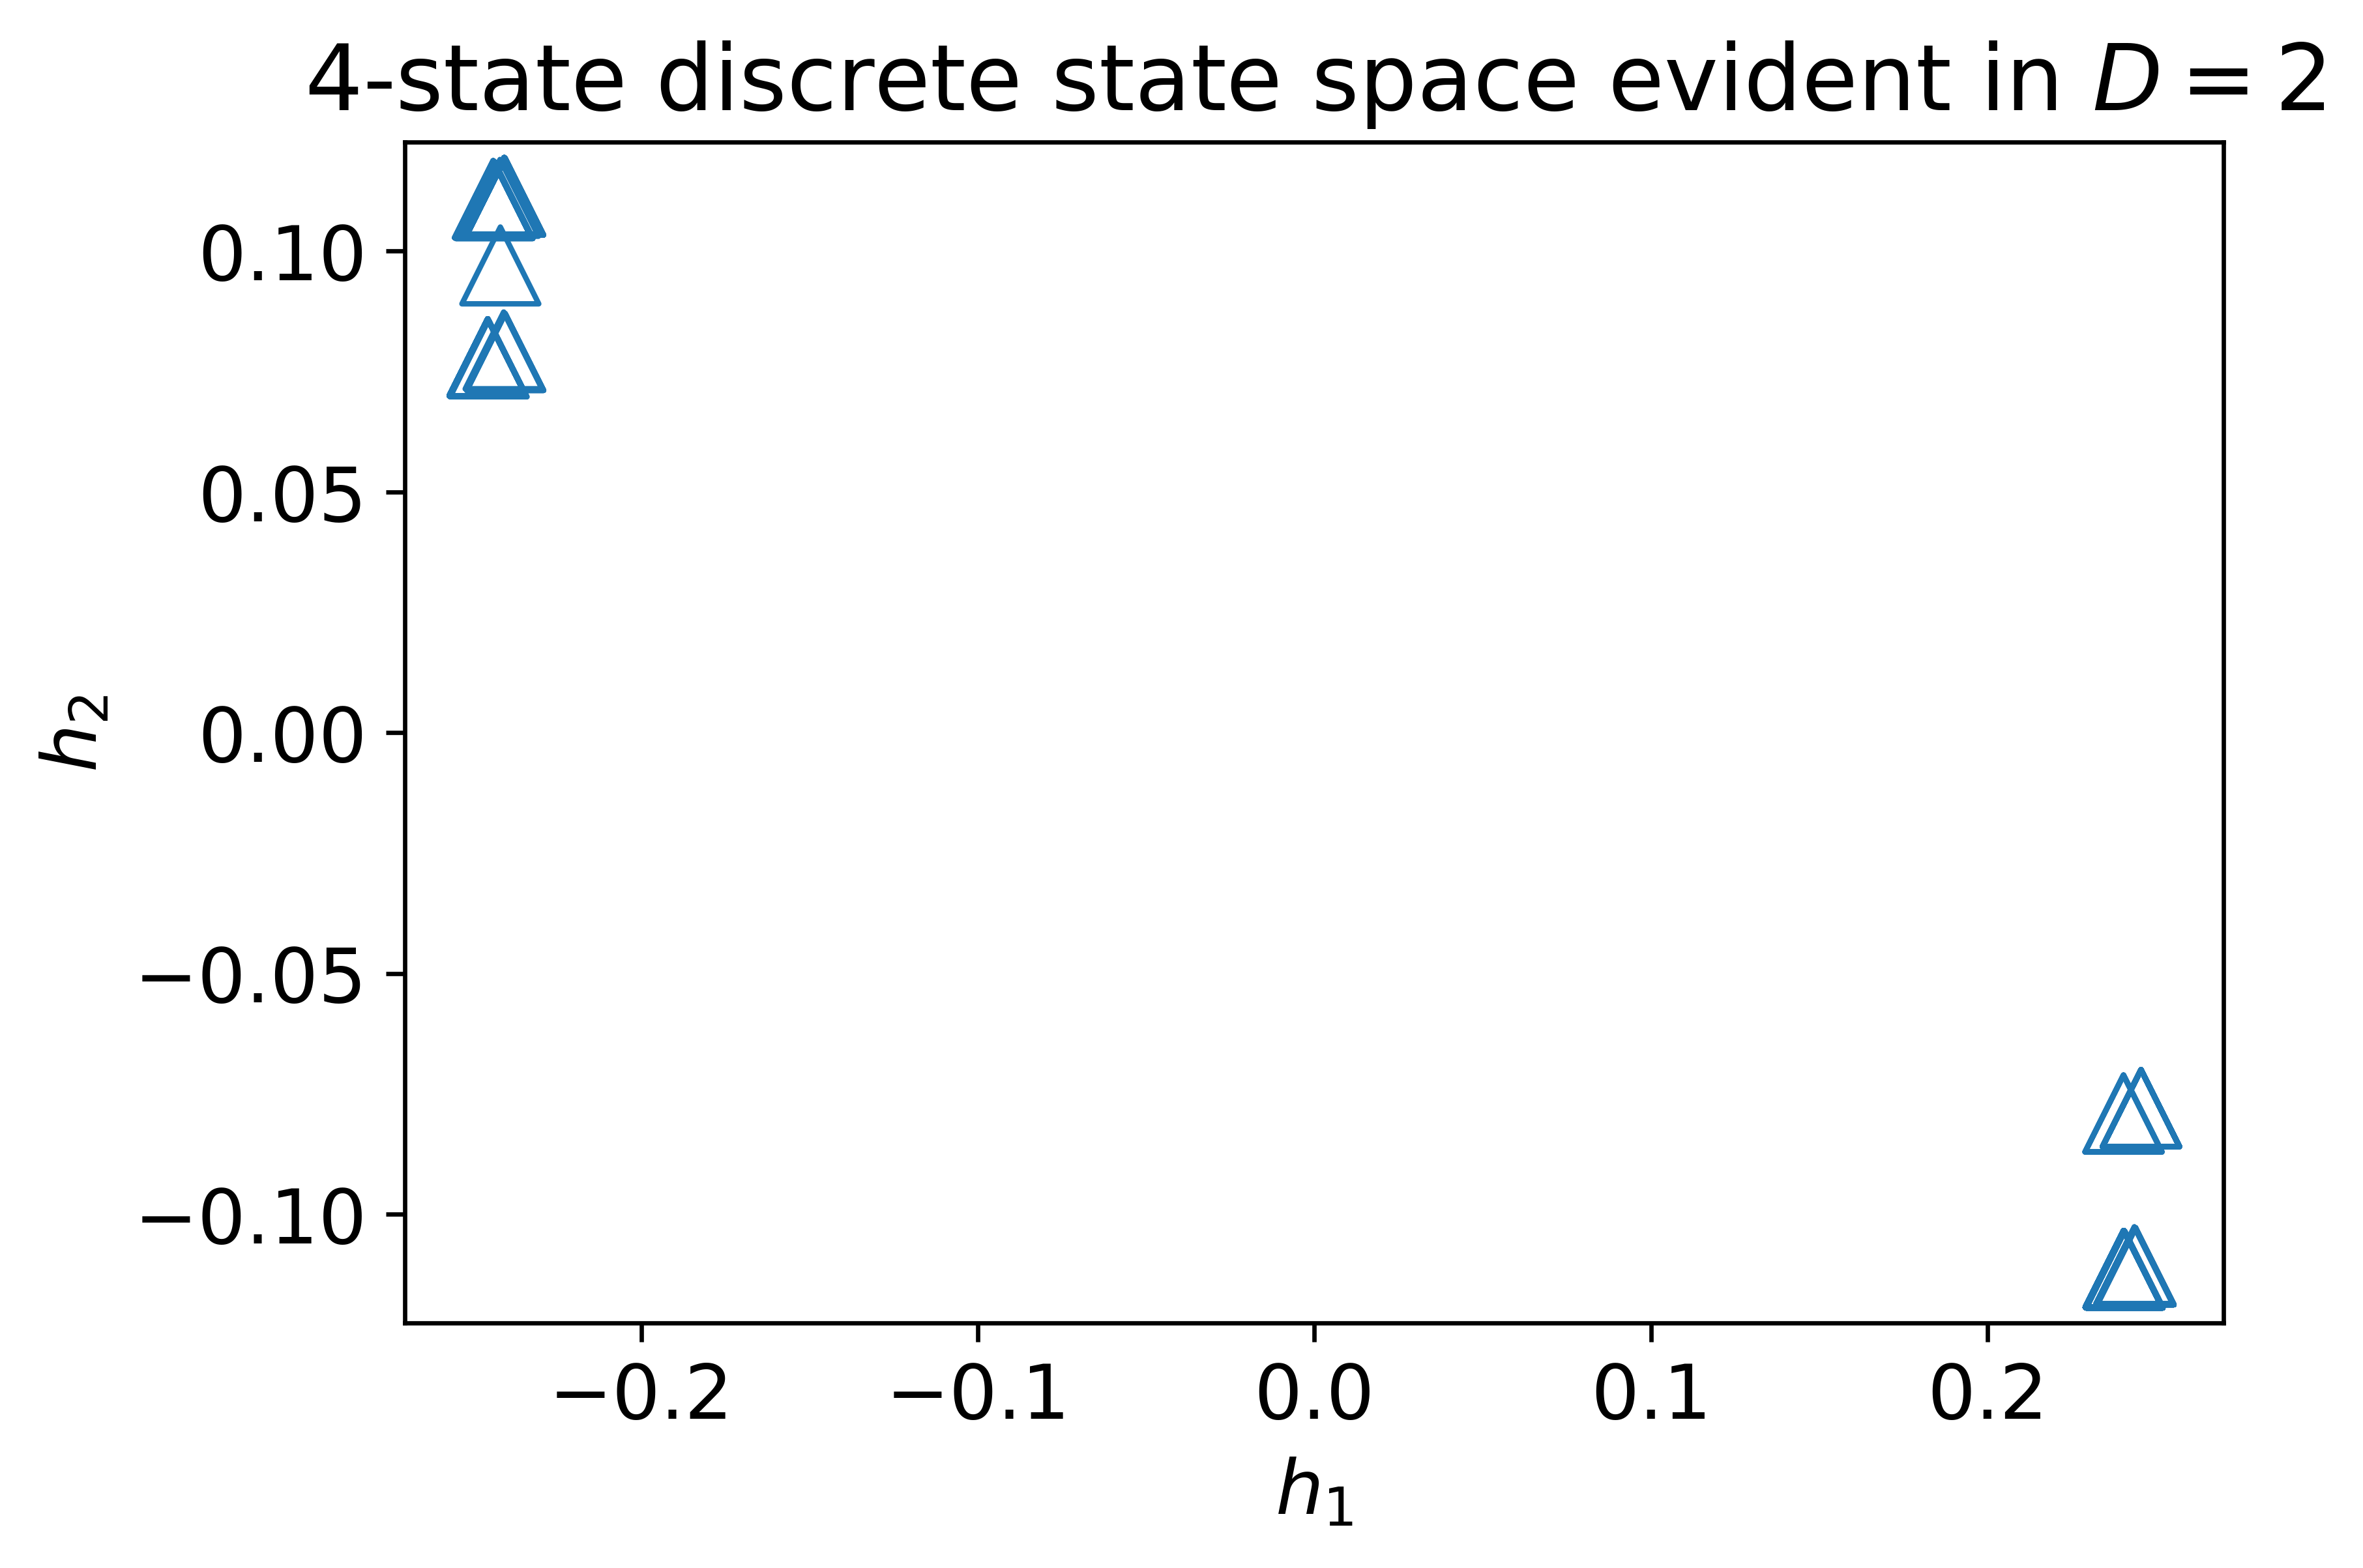

In [37]:
cmap = mpl.cm.get_cmap(name="tab10")
fig = plt.figure()
fig.set_size_inches(6,4)
fig.set_dpi(300)
ax = fig.add_subplot(111)

plt.scatter(proj_data[:,0], proj_data[:,1], s=200, marker="^", facecolors="none", edgecolors=cmap.colors[0])

plt.ylabel(r"$h_2$")
plt.xlabel(r"$h_1$")
plt.title("4-state discrete state space evident in $D=2$")

In [38]:

if hidden_size == 1:
    reduced_hdata = hdata
else:
    reduced_hdata, evals, _ = pca(hdata, pc_count=1)
#reduced_hdata = reduced_hdata/np.max(reduced_hdata)*0.8

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Longer interactions induce more RNN states.')

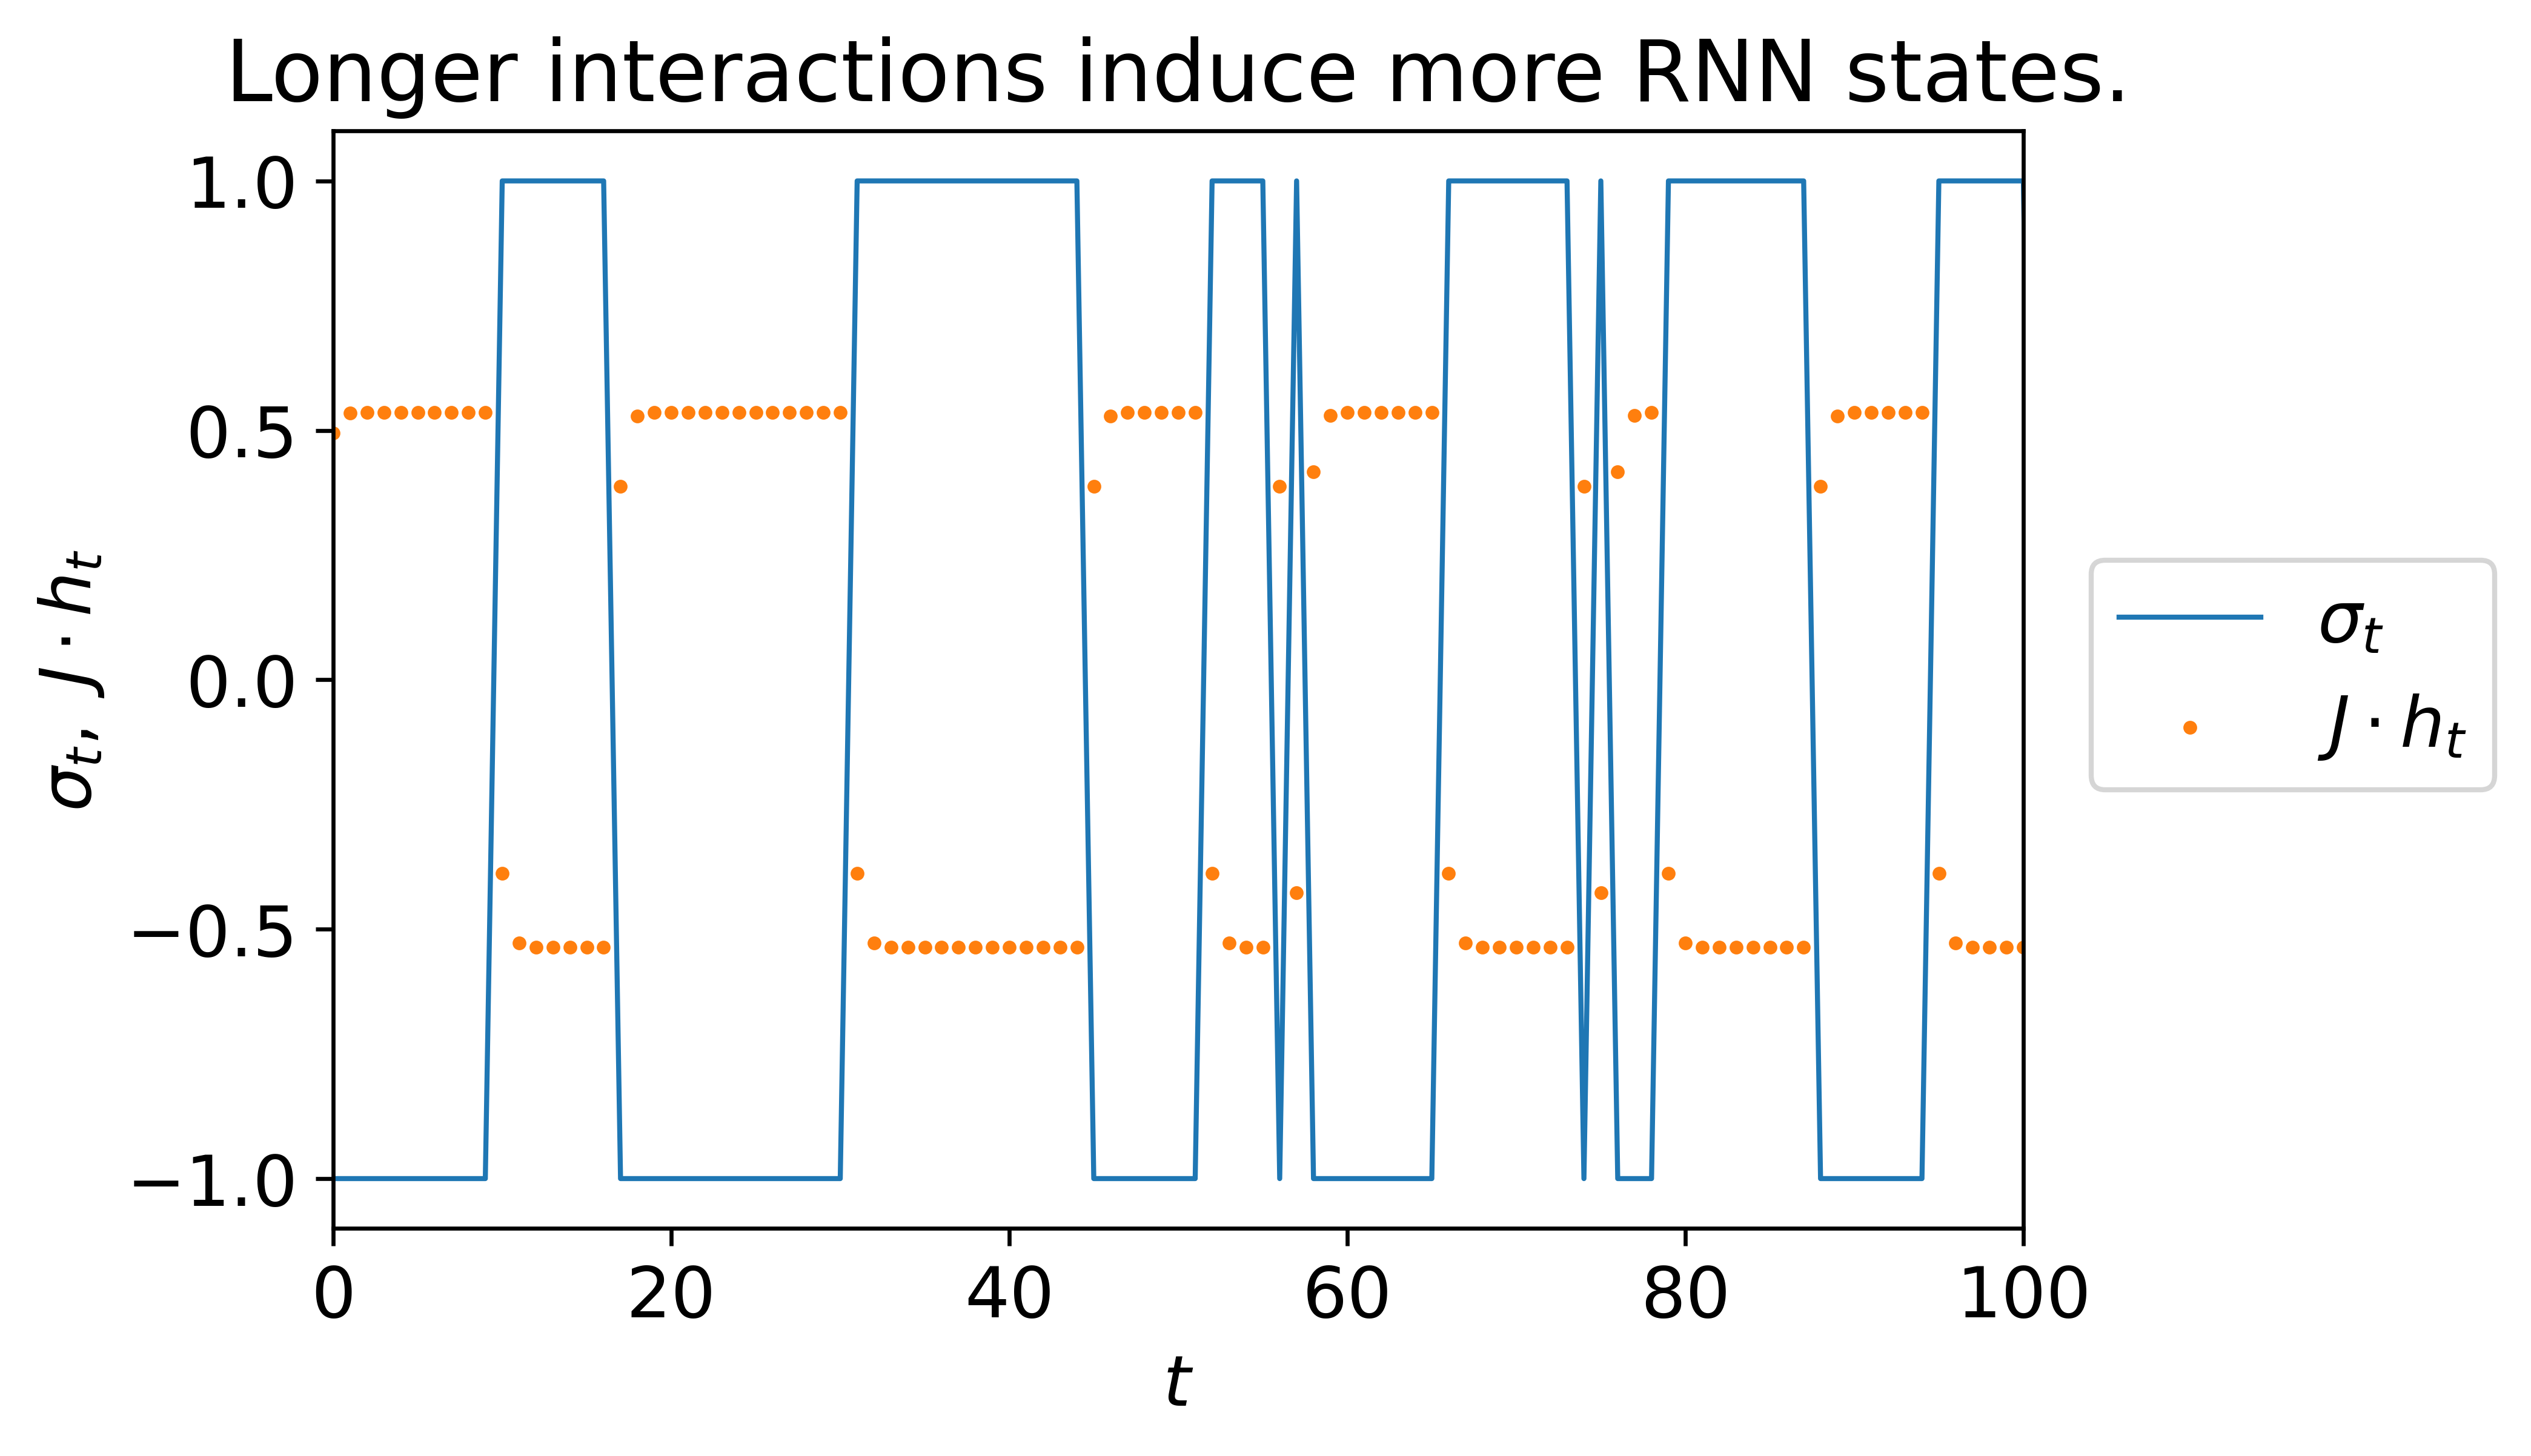

In [55]:
cmap = mpl.cm.get_cmap(name="tab10")
fig = plt.figure()
fig.set_size_inches(6,4)
fig.set_dpi(300)
ax = fig.add_subplot(111)
xdata = np.arange(999)
ax.plot(spindata, c=cmap.colors[0], linewidth=1, label=r"$\sigma_t$")
ax.scatter(x=xdata, y=reduced_hdata, c=cmap.colors[1], s=3, label=r"$J \cdot h_t$")
ax.legend(loc=(1.04,0.4))
ax.set_xlim([0,100])
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\sigma_t,$ $J \cdot h_t$")
ax.set_title("Longer interactions induce more RNN states.")



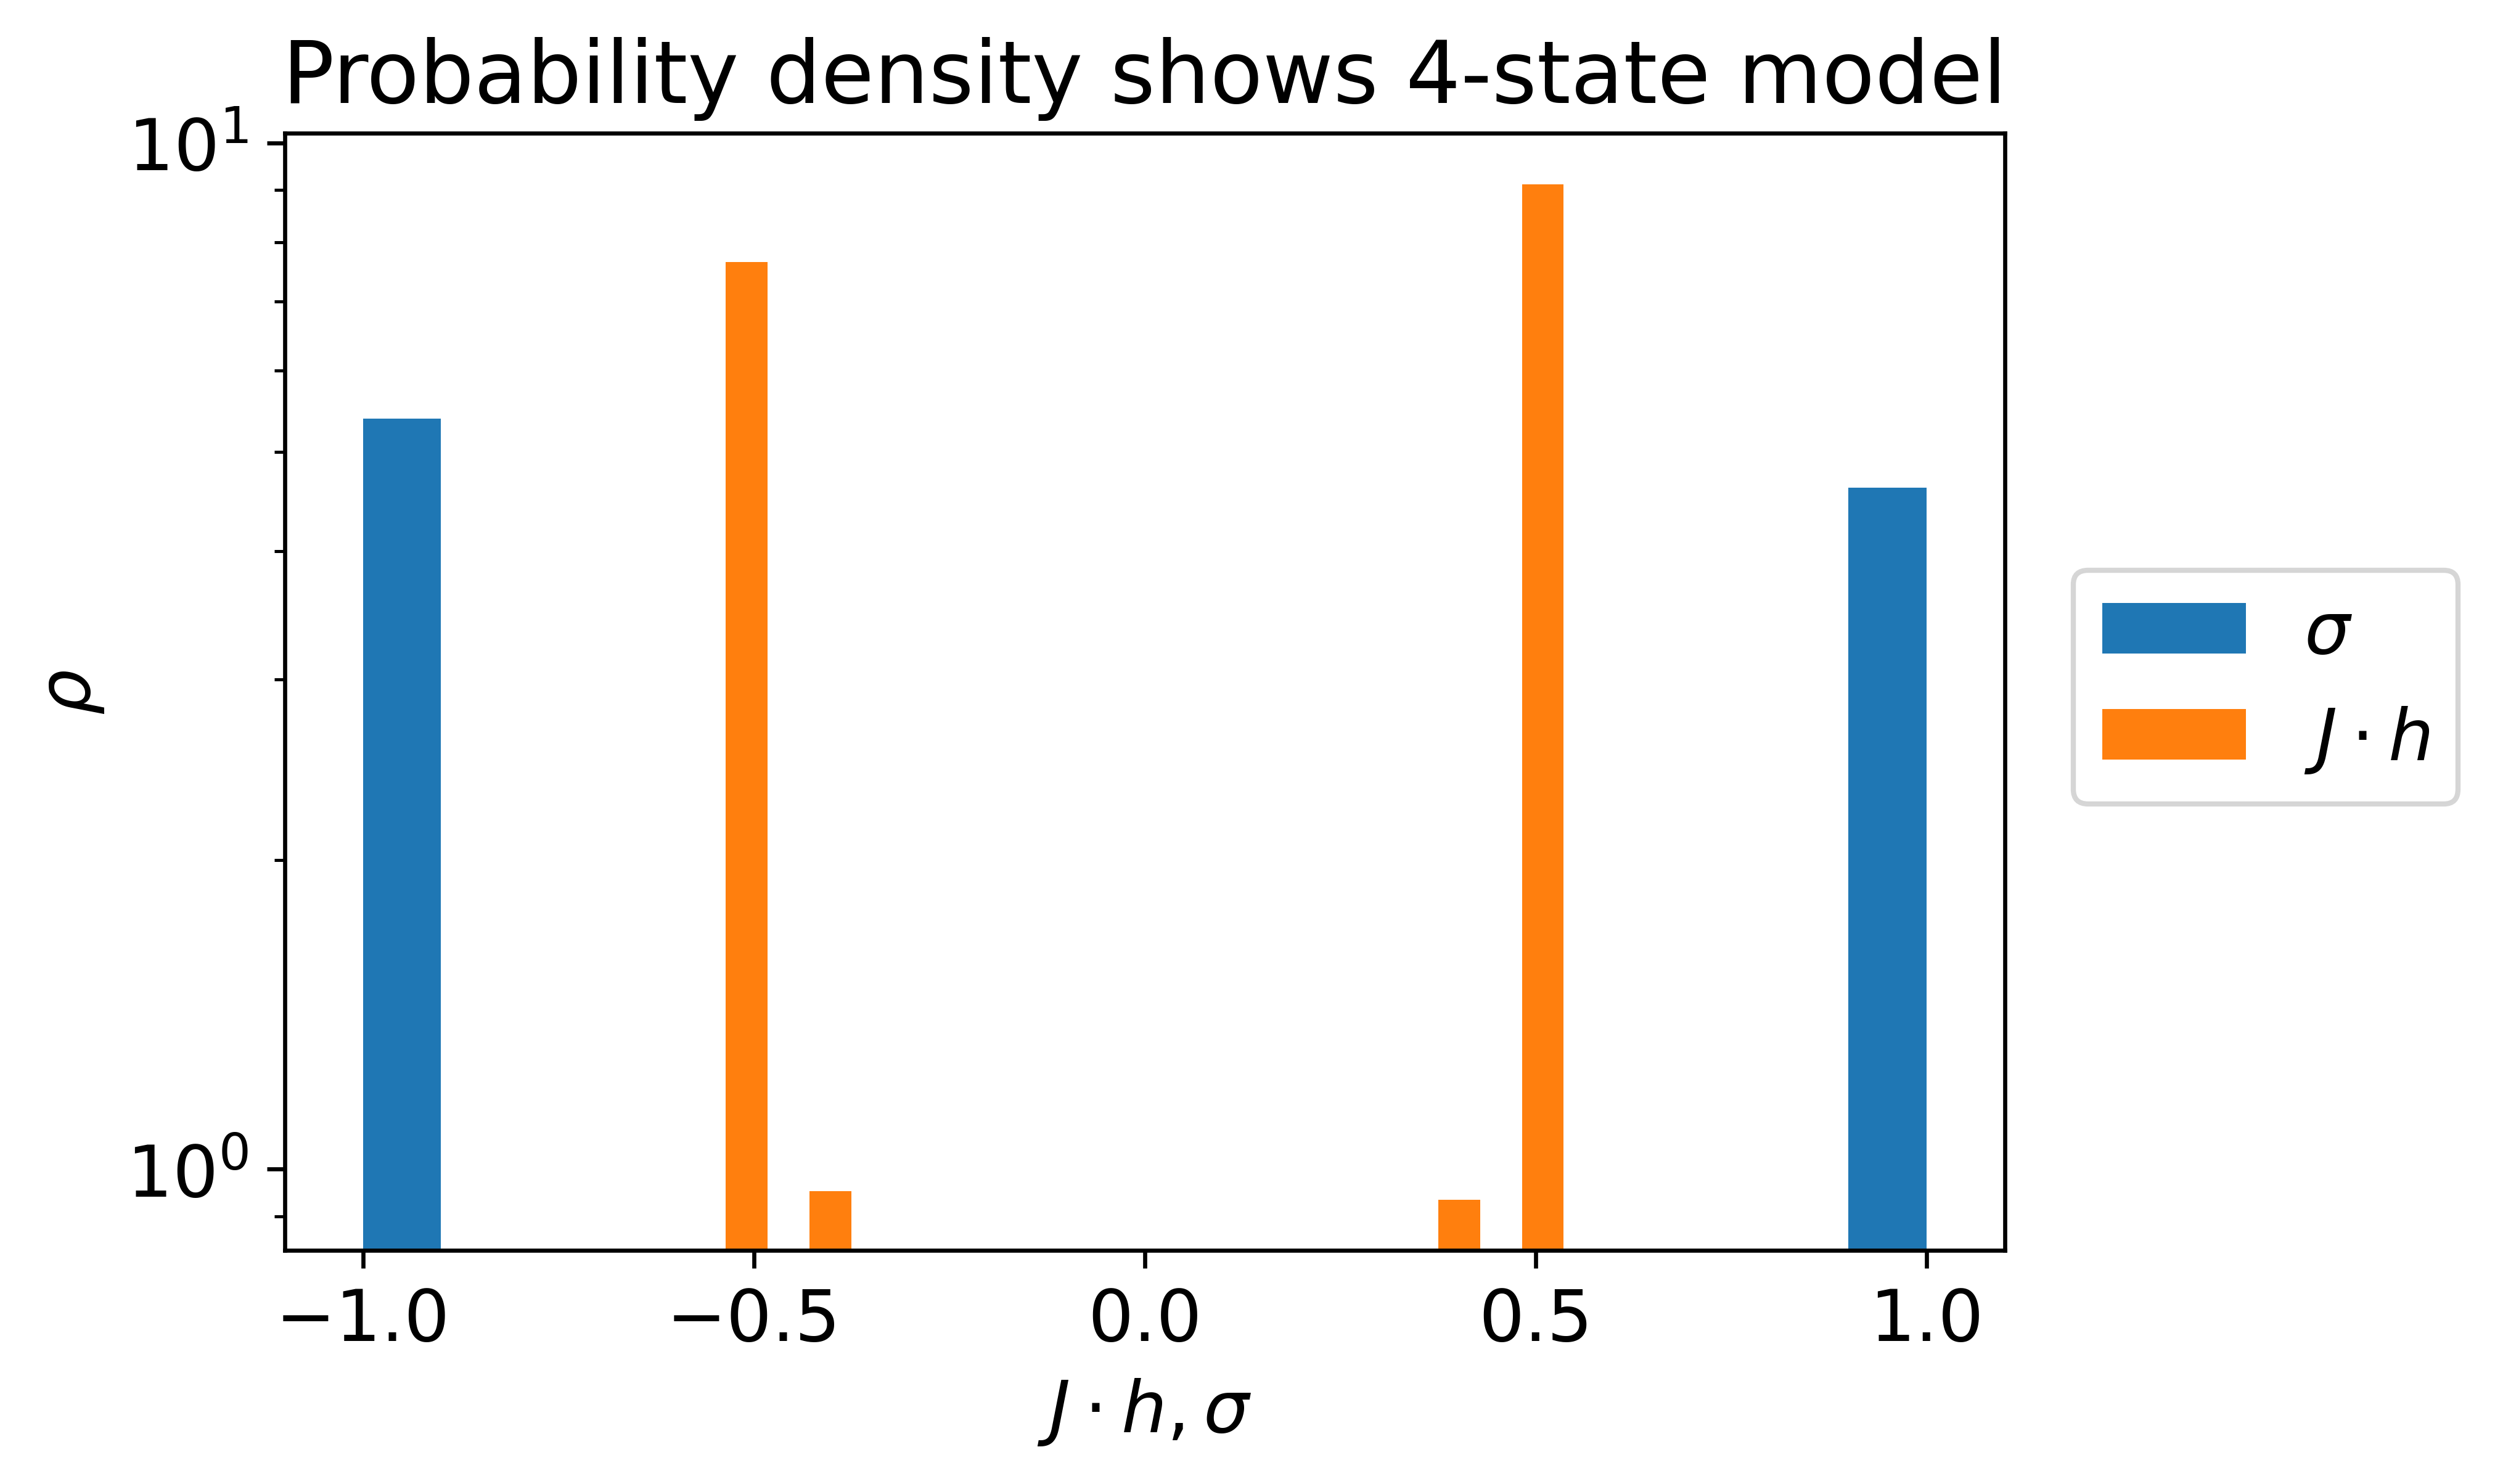

In [57]:
bins=20
cmap = mpl.cm.get_cmap(name="tab10")
fig = plt.figure()
fig.set_size_inches(6,4)
fig.set_dpi(300)
ax = fig.add_subplot(111)
xdata = np.arange(999)
hist_spindata = plt.hist(spindata, bins=bins, density=True, color=cmap.colors[0], label=r"$\sigma$")
hist_hdata = plt.hist(reduced_hdata, bins=bins, density=True, color=cmap.colors[1], label=r"$J \cdot h$")
ax.legend(loc=(1.04,0.4))

plt.title(r"Probability density shows 4-state model")
plt.xlabel(r"$J\cdot h,\sigma$")
plt.ylabel(r"$\rho$")
plt.yscale("log")



# 2D

In [25]:
def get_spin_file(kfrac):
    res_dir = "/Users/jesselin/Dropbox/src/thesis/experiments/rnn_compiled/test_res_dir/compiled tensors"
    search_term = "compiled*"
    raw_file_list = glob.glob(os.path.join(res_dir, search_term))
    raw_file_list.sort()
    spin_file_dict = {round(1/float(get_T(f))/INTERACTION_Kc, 2):f for f in raw_file_list}
    return spin_file_dict[kfrac], spin_file_dict

## Get trained RNNs

In [26]:
def get_model(kfrac, hidden_size, trial_num):
    res_dir = "/Users/jesselin/Dropbox/src/thesis/experiments/rnn/2d_cluster_data/compiled tight nn"
    search_term = "logs_2D*"
    raw_file_list = glob.glob(os.path.join(res_dir, search_term))
    raw_file_list.sort()
    model_dir_dict = {round(float(get_K(f))/INTERACTION_Kc, 2):f for f in raw_file_list}
    checkpoint_dir = os.path.join(model_dir_dict[kfrac], f"hidden_size={hidden_size}/version_{trial_num}/checkpoints")
    checkpoint_basename, = os.listdir(checkpoint_dir)
    checkpoint = os.path.join(checkpoint_dir, checkpoint_basename)
    return IsingRNN_compat.load_from_checkpoint(checkpoint)

In [172]:
# outline
kfrac = 1
hidden_size = 2
trial_num = 2

spin_filepath, _ = get_spin_file(kfrac)
dataset = SpinSequenceDataset(spin_filepath, interaction_K=[kfrac*INTERACTION_Kc])
num_samples = len(dataset)
model = get_model(kfrac, hidden_size, trial_num)
spindata_arr, hdata_arr = get_hdata(model, dataset, num_samples=10)

100%|██████████| 10/10 [00:00<00:00, 128.71it/s]


In [173]:
for x in hdata_arr:
    y = pca(x, pc_count=1)
    evals = y[1]
    print("Variance captured", np.max(evals)/np.sum(evals))

Variance captured 0.9523082
Variance captured 0.9746361
Variance captured 0.9638941
Variance captured 0.9591269
Variance captured 0.9639716
Variance captured 0.97595394
Variance captured 0.95905846
Variance captured 0.9744566
Variance captured 0.9578124
Variance captured 0.949763


In [161]:
hdata = hdata_arr[0]

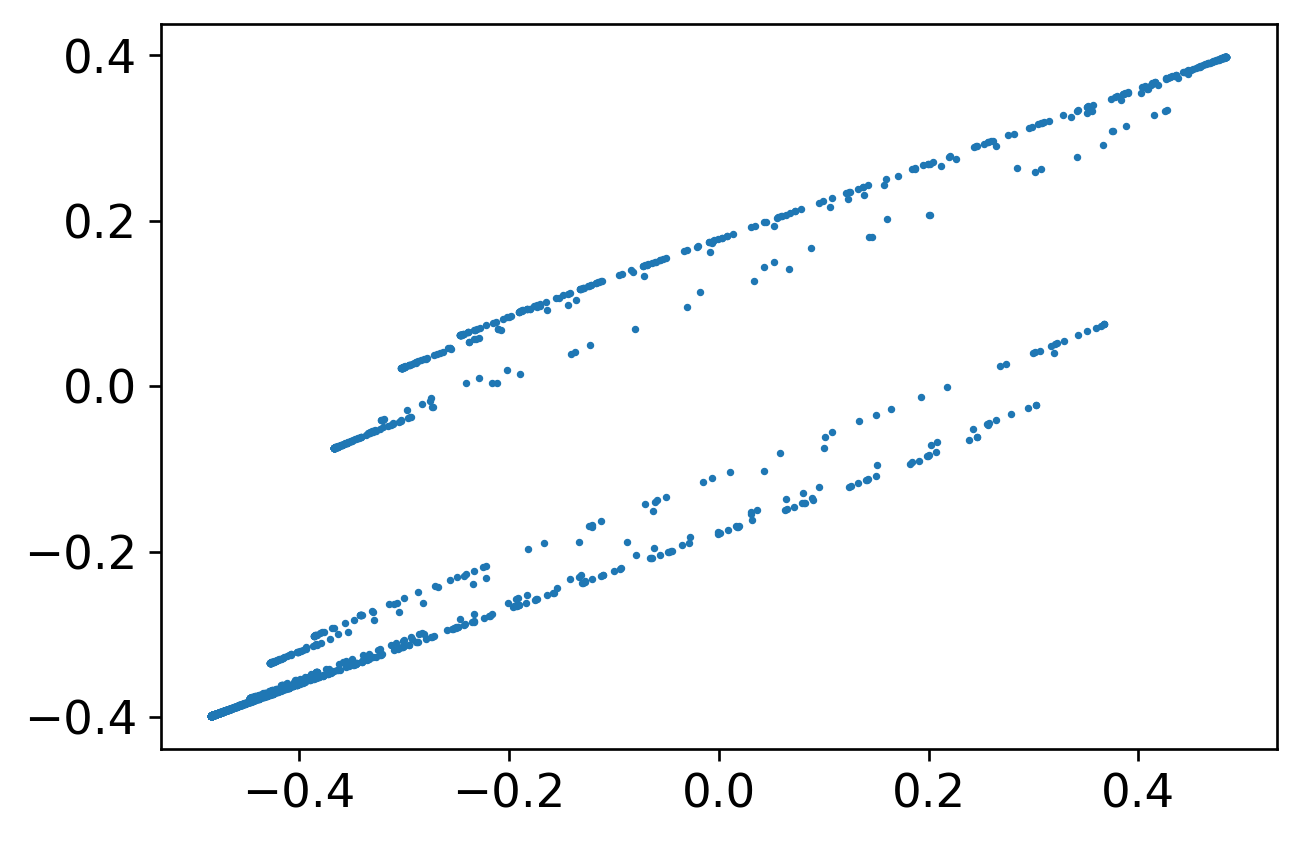

In [162]:
y, _, _ = pca(hdata_arr[0], pc_count=2)
plt.scatter(hdata[:,0], hdata[:,1], s=1.5)

In [27]:
# outline
kfrac = 1
hidden_size = 2
trial_num = 2

spin_filepath, _ = get_spin_file(kfrac)
dataset = SpinSequenceDataset(spin_filepath, interaction_K=[kfrac*INTERACTION_Kc])
num_samples = len(dataset)
model = get_model(kfrac, hidden_size, trial_num)
spindata_arr, hdata_arr = get_hdata(model, dataset, num_samples=10)
hdata_2d = hdata_arr[0]

100%|██████████| 10/10 [00:00<00:00, 178.02it/s]


In [28]:
hidden_size = 2
model = IsingRNN_simple.load_from_checkpoint(f"/Users/jesselin/Dropbox/src/thesis/final/data/1D/LR/adroit_K=[1.0, 0.3, 0.1]/hidden_size=2/version_0/checkpoints/epoch=99-step=999.ckpt")
dataset = SpinSequenceDataset("/Users/jesselin/Dropbox/src/thesis/final/resources/1D/LR/arr_sampledata_K=[1.  0.3 0.1].npz", interaction_K=[1.0, 0.3, 0.1])

In [29]:
s, h = get_hdata(model, dataset, 1)
spindata, hdata_1dNNNN = s[0], h[0]
hdata_1dNNNN = hdata_1dNNNN/np.std(hdata_1dNNNN, axis=0)
hdata_2d = hdata_2d/np.std(hdata_2d, axis=0)


100%|██████████| 1/1 [00:00<00:00, 336.43it/s]


Text(0.5, 1.0, 'State space of $D=2$ encodings')

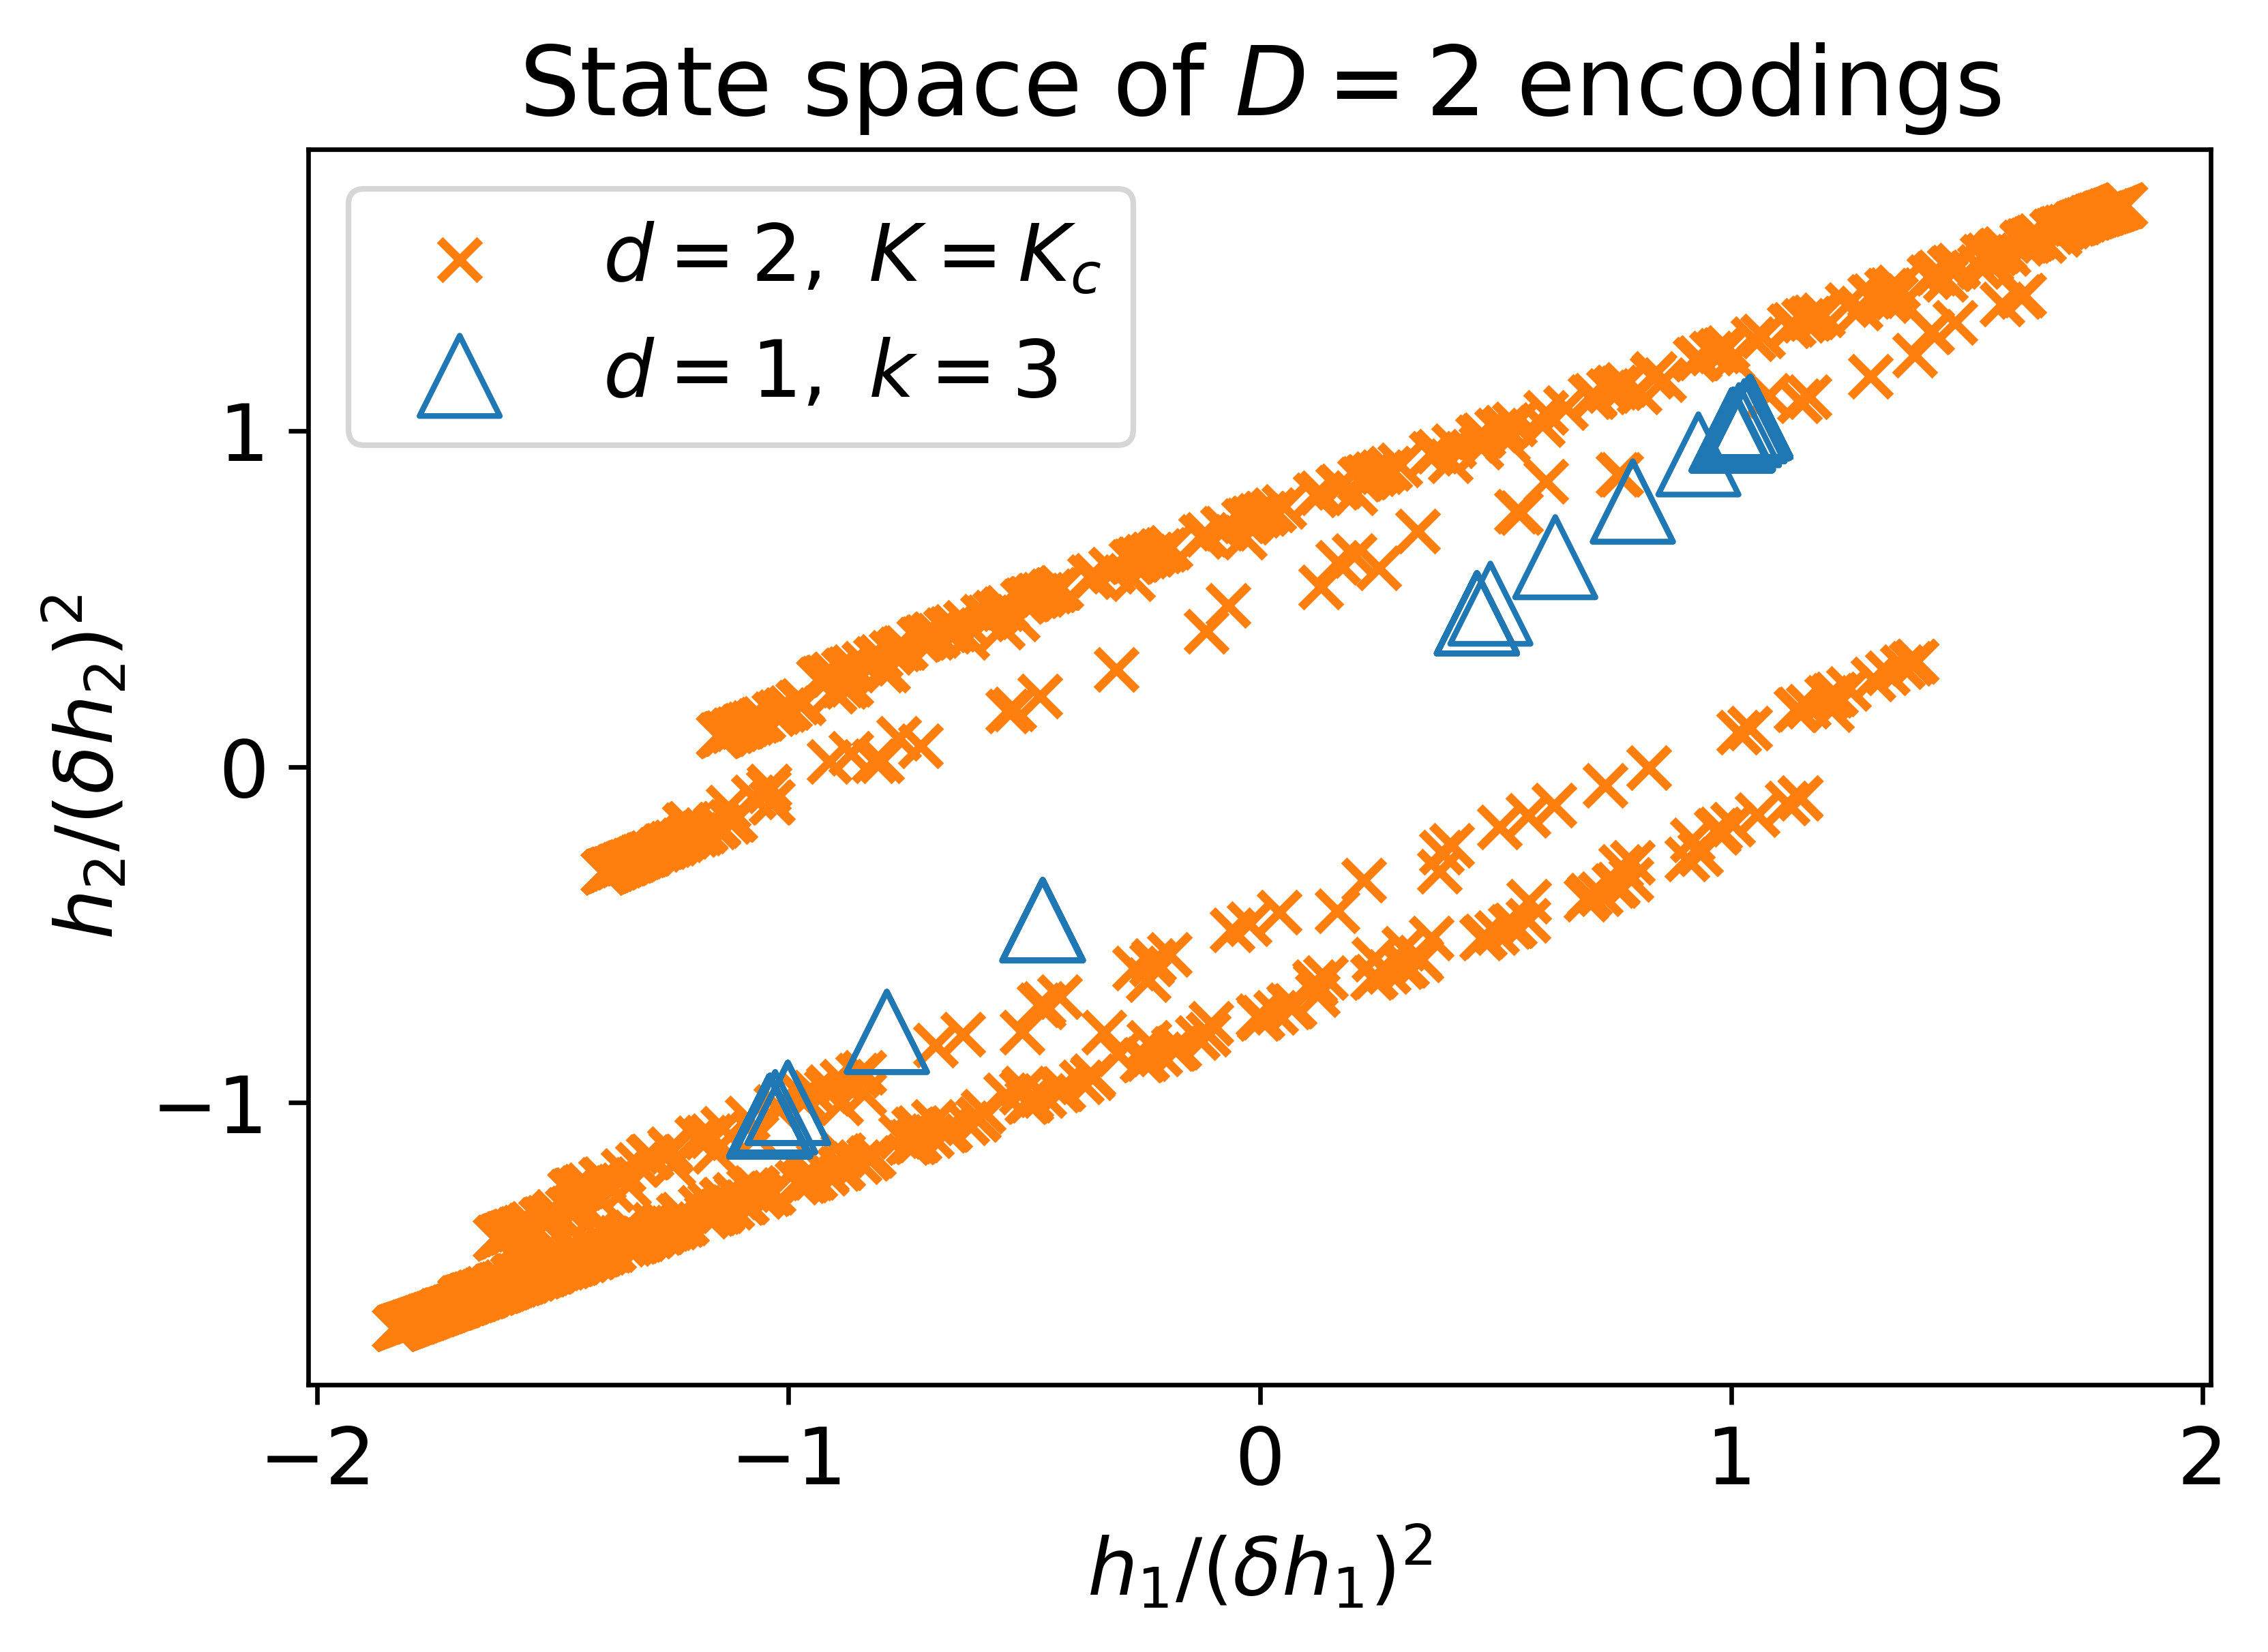

In [32]:
cmap = mpl.cm.get_cmap(name="tab10")
fig = plt.figure()
fig.set_size_inches(6,4)
fig.set_dpi(300)
ax = fig.add_subplot(111)

plt.scatter(hdata_2d[:,0], hdata_2d[:,1], s=50, marker="x", color=cmap.colors[1], label=r"$d=2,\ K=K_c$")
plt.scatter(hdata_1dNNNN[:,0], hdata_1dNNNN[:,1], s=200, marker="^", facecolors="none", edgecolors=cmap.colors[0], label=r"$d=1,\ k=3$")
plt.legend()
plt.ylabel(r"$h_2/(\delta h_2)^2$")
plt.xlabel(r"$h_1/(\delta h_1)^2$")
plt.title("State space of $D=2$ encodings")


In [168]:
if hidden_size == 1:
    reduced_hdata = hdata
else:
    reduced_hdata, evals, _ = pca(hdata_arr[0], pc_count=1)
#reduced_hdata = reduced_hdata/np.max(reduced_hdata)*0.8

In [ ]:
reduced_hdata.shape

Text(0.5, 1.0, 'Nearly continuous state space at criticality')

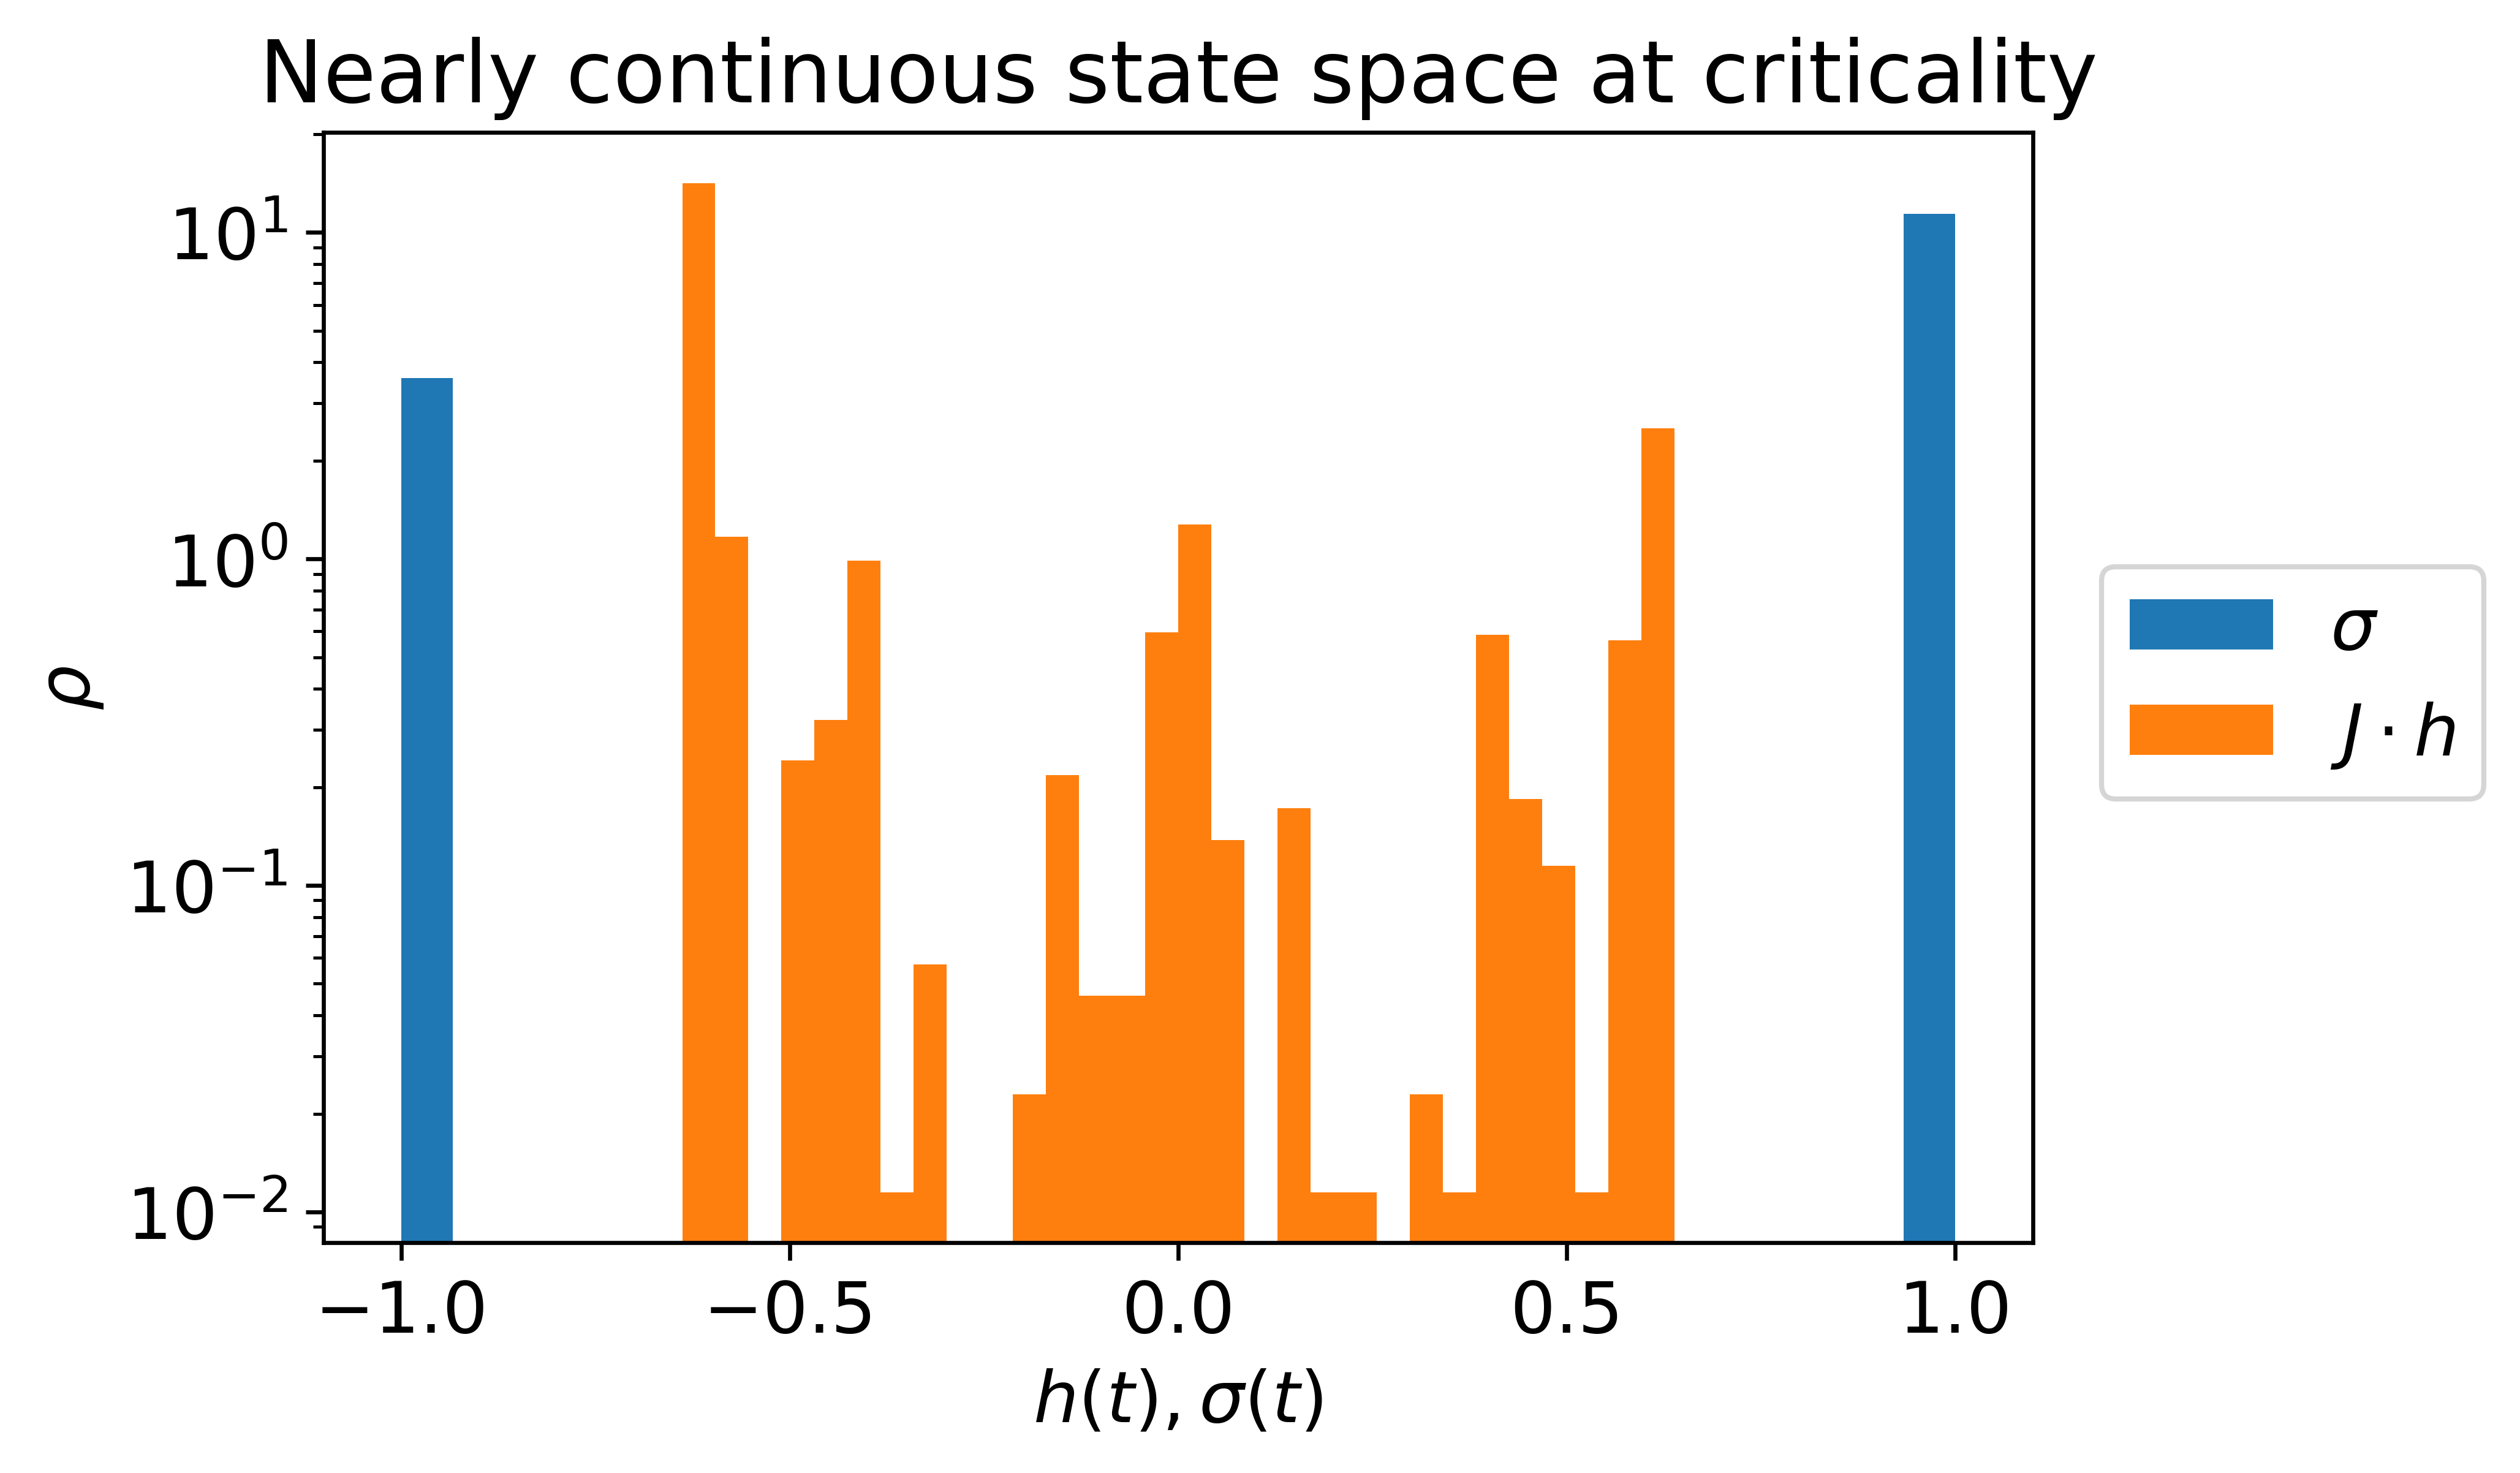

In [157]:
spin_dynamics_histogram(spindata, reduced_hdata, bins=30, length=2047)
plt.title("Nearly continuous state space at criticality")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Dynamics with many states at criticality.')

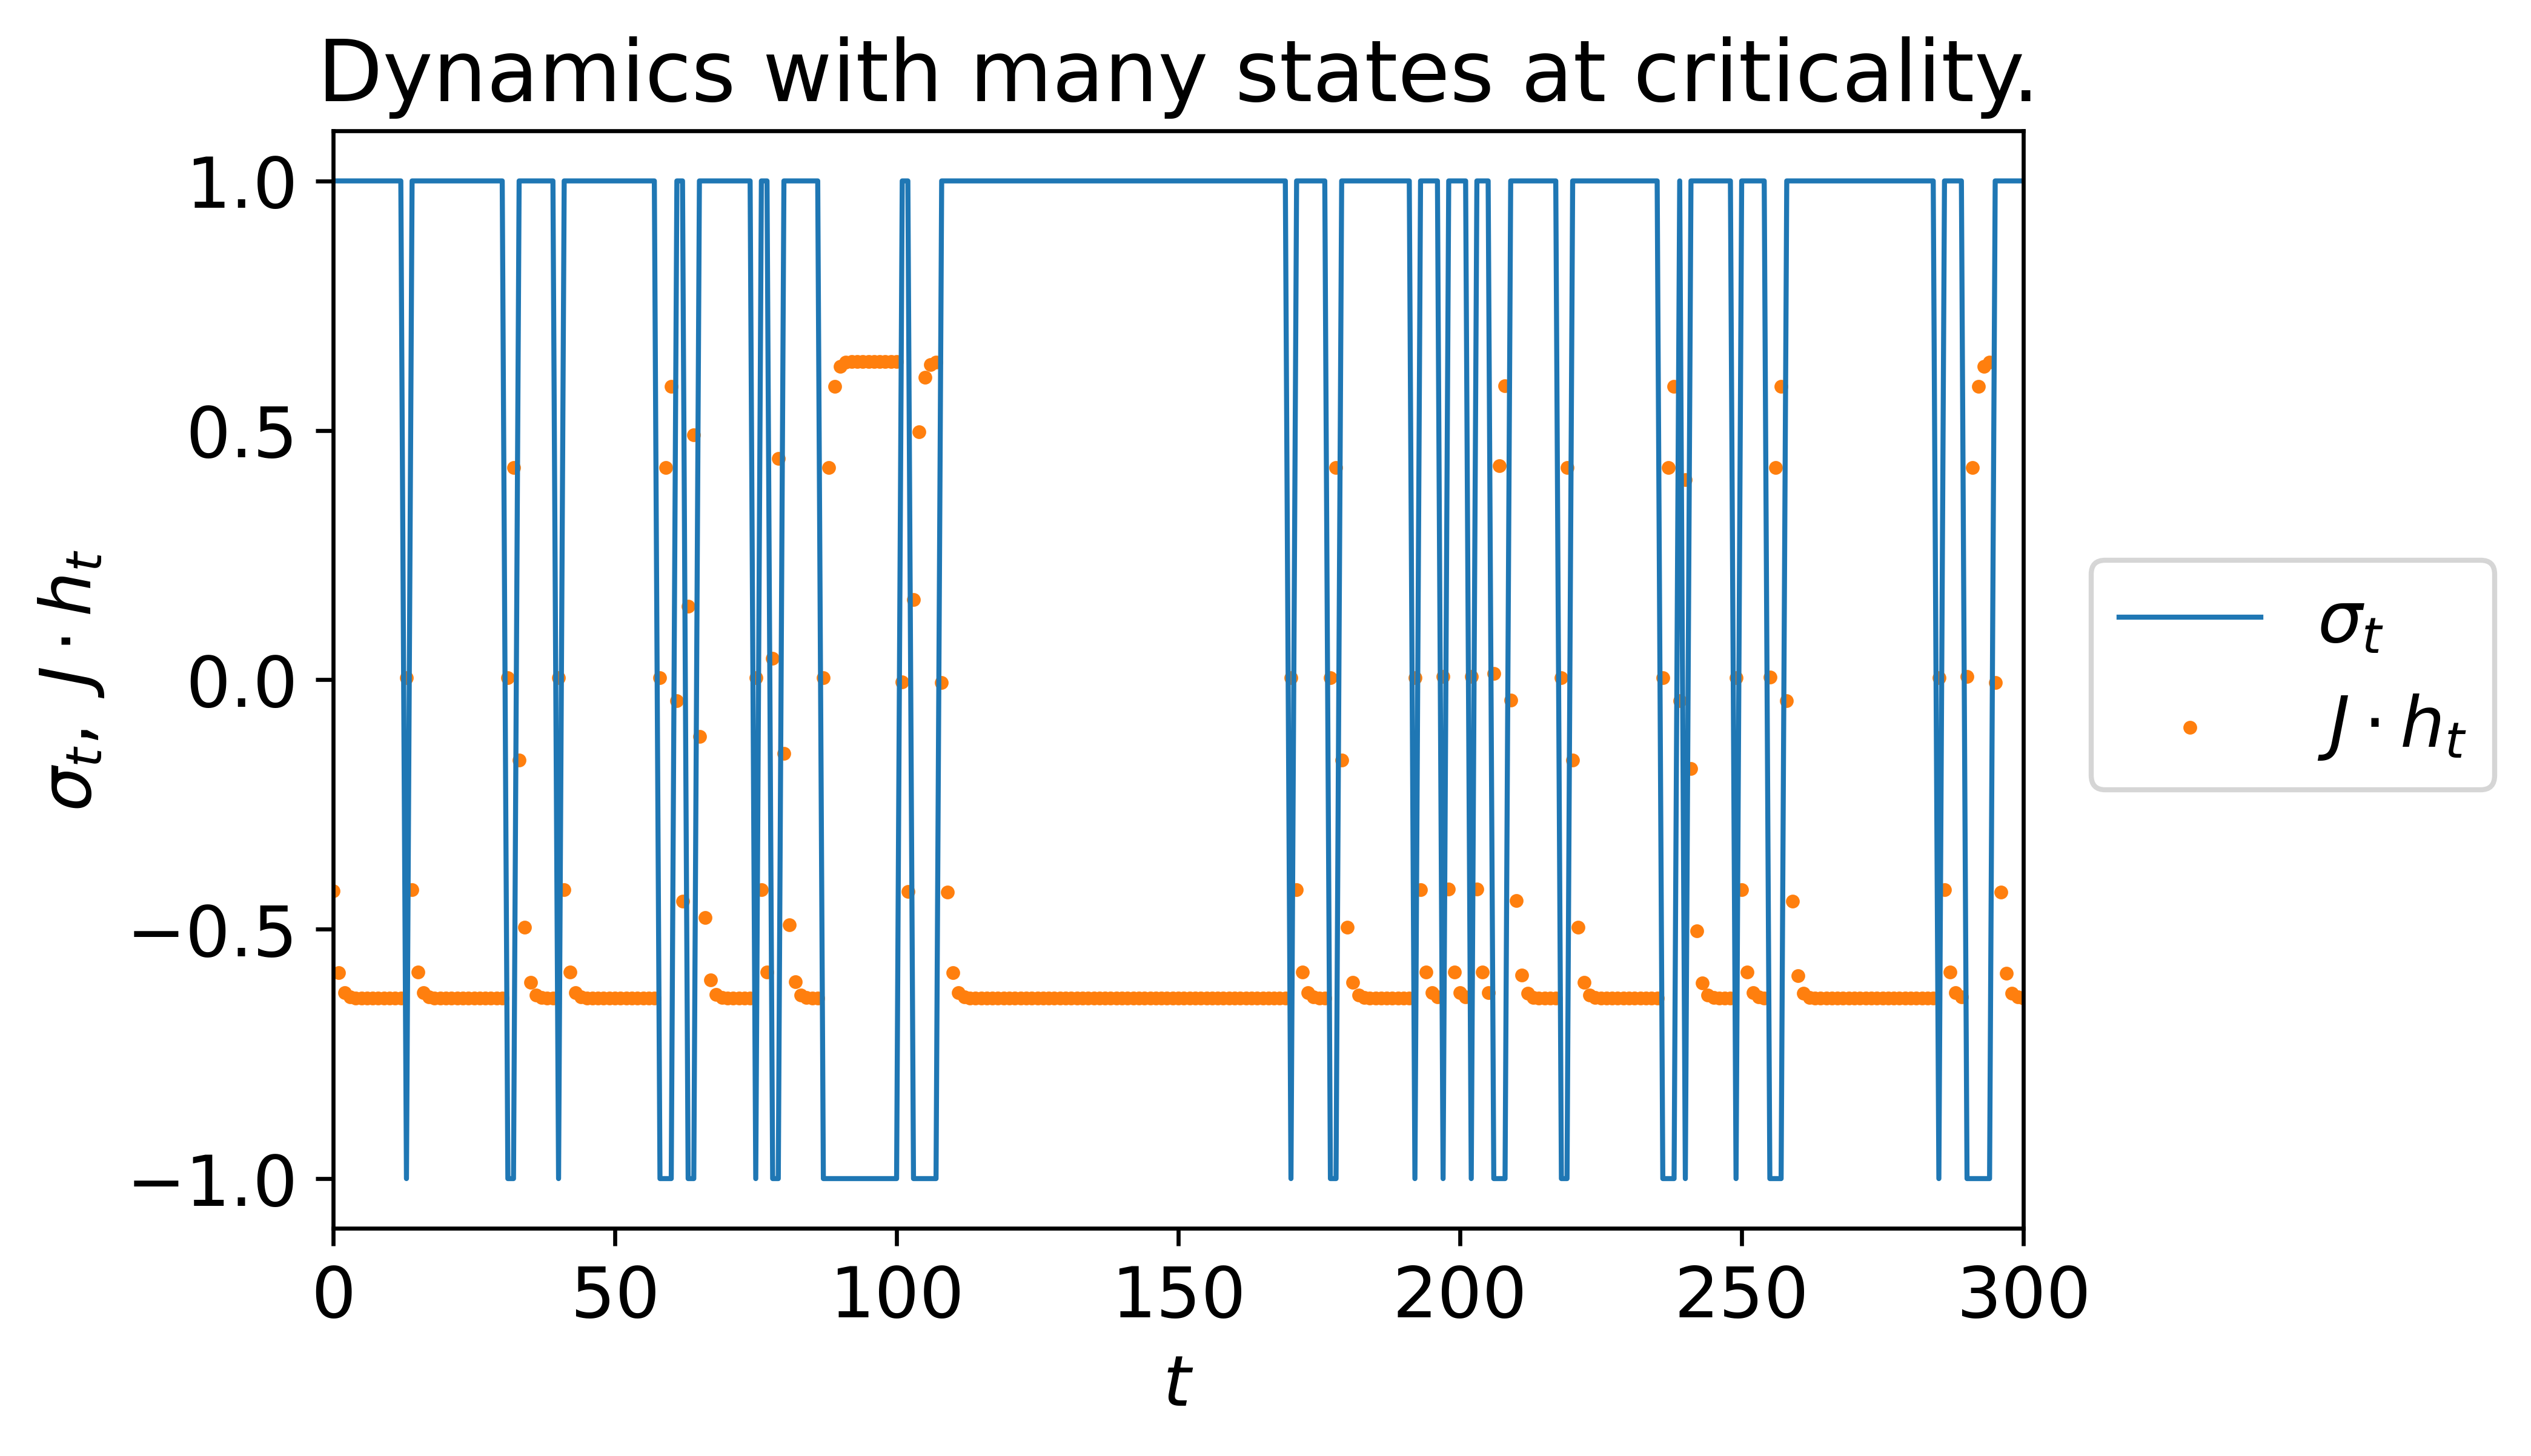

In [154]:
spin_history(spindata, reduced_hdata, length=2047)
plt.xlim([0, 300])
plt.title("Dynamics with many states at criticality.")

Text(0.5, 1.0, '$h(t)$ compared to 2D critical sequences')

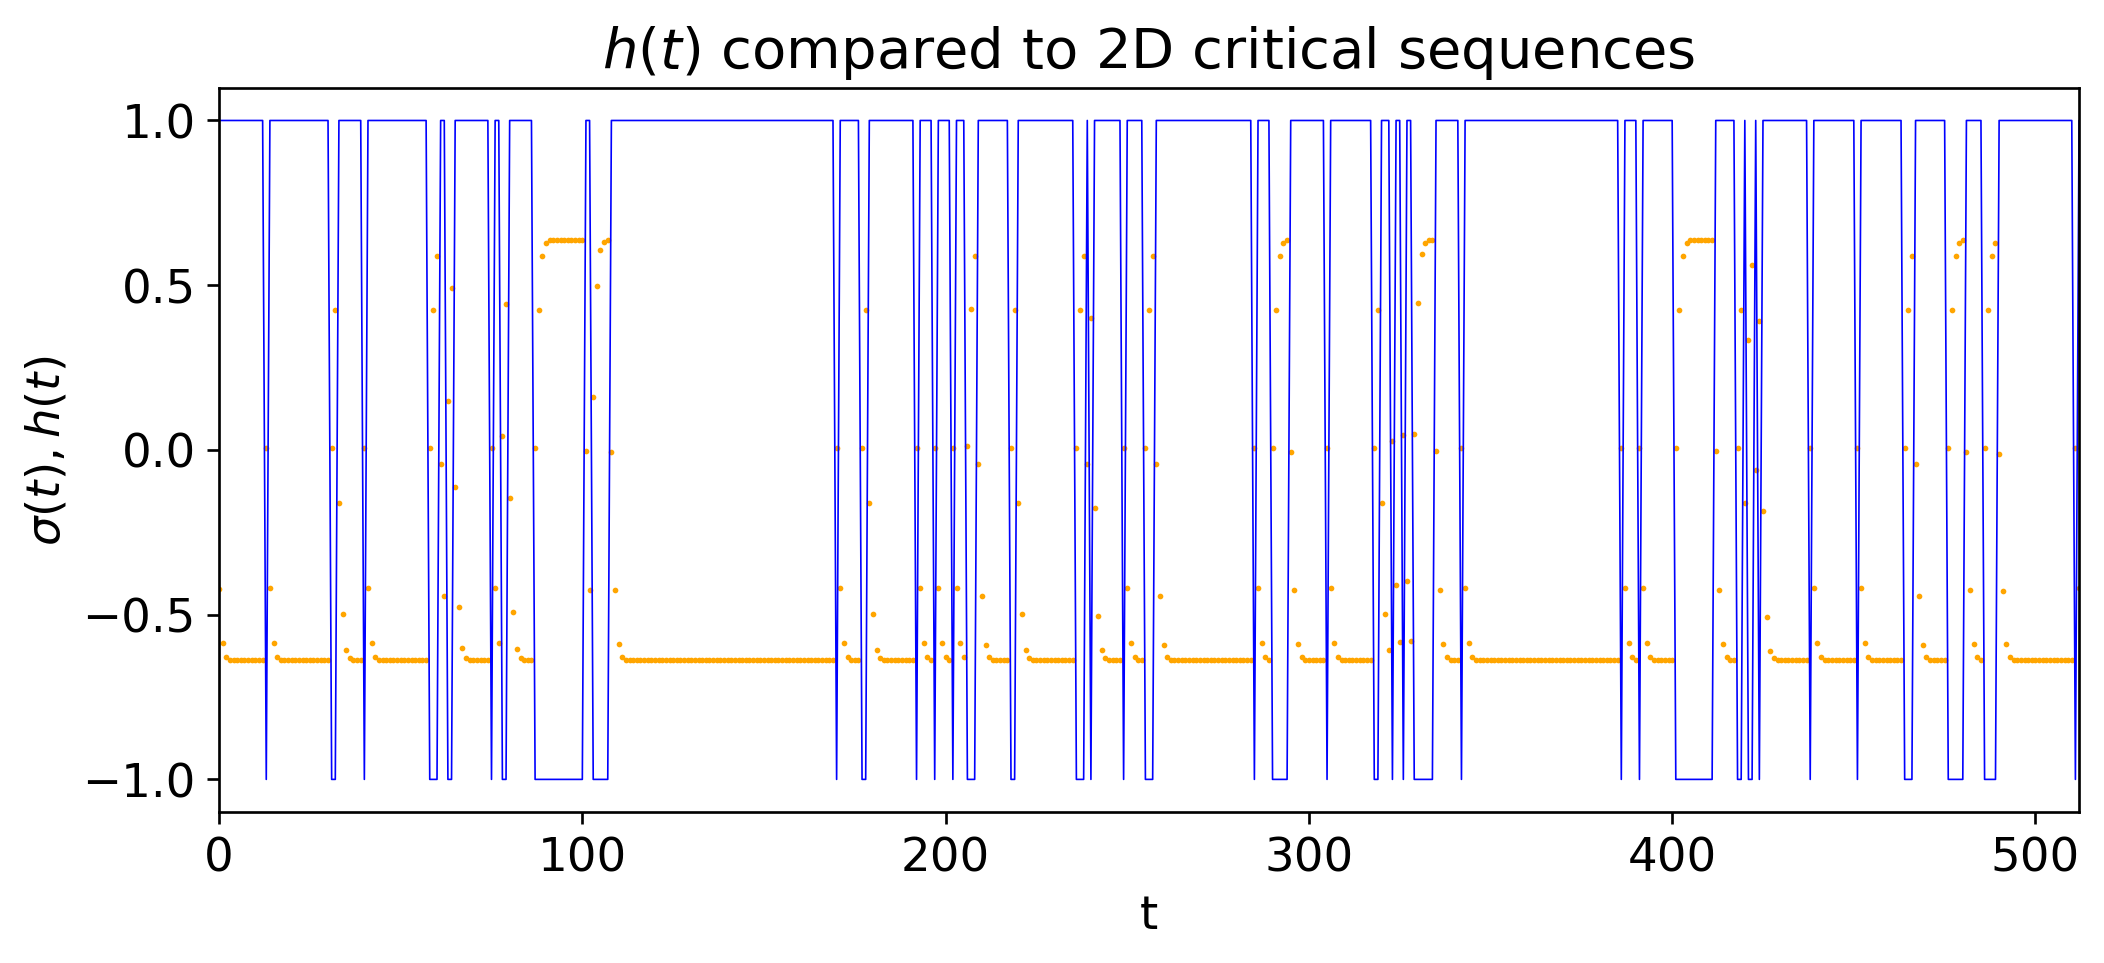

In [143]:
plt.figure(figsize=(10,4))
xdata = np.arange(len(reduced_hdata))
plt.plot(xdata, spindata, linewidth=0.5,c="blue")
plt.scatter(xdata, reduced_hdata, s=0.5,c="orange")
plt.xlim([0,512])

plt.ylabel(r"$\sigma(t), h(t)$")
plt.xlabel(r"t")
plt.title(r"$h(t)$ compared to 2D critical sequences")

Text(0, 0.5, '$\\rho$')

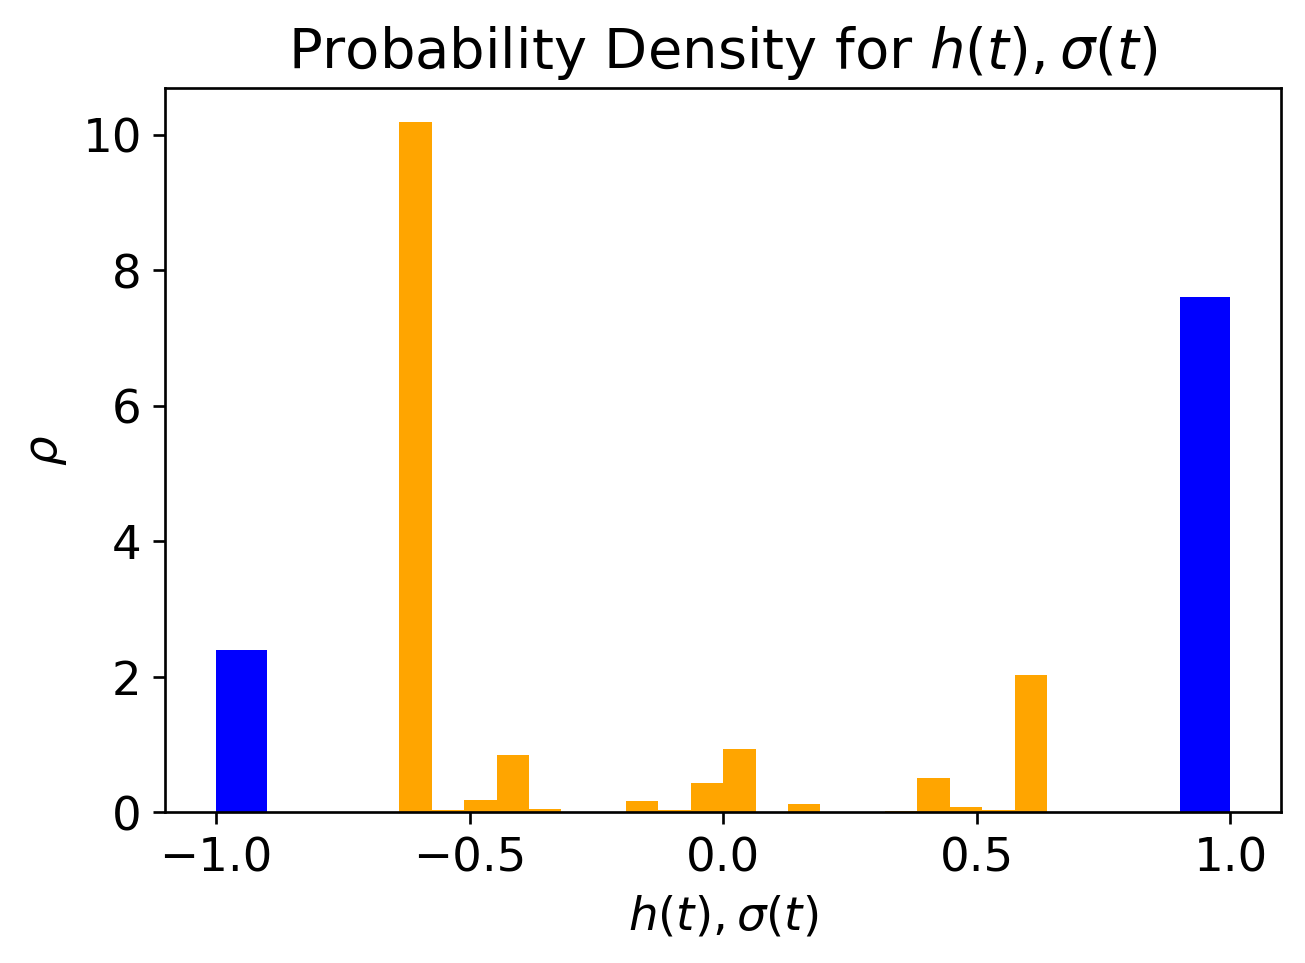

In [144]:
bin_count = 20
hist_spindata = plt.hist(spindata, bins=bin_count, density=True, color="blue")
hist_hdata = plt.hist(reduced_hdata, bins=bin_count, density=True, color="orange")
plt.title(r"Probability Density for $h(t), \sigma(t)$")
plt.xlabel(r"$h(t),\sigma(t)$")
plt.ylabel(r"$\rho$")

# Graphs

In [139]:
def update_rule(h, th, j, hstates):
    j = j.detach().numpy()
    th = th.detach().numpy()
    transition_rules = {}
    for s in [-1, 1]:
        out_state = j*np.tanh(j*h + th*s)
        out_state = out_state.item()
        out_hstate = np.argmin(np.abs(out_state - np.array(hstates)))
        transition_rules[s] = (out_hstate, out_state)
    return transition_rules

In [140]:
def update_rule_2state(h1, th, j, hstates):
    initial_conds = np.array([[-1.,-1.], [-1., 1.], [1., -1.], [1.,1.]])
    j = j.detach().numpy()
    th = th.detach().numpy()
    transition_rules = {}
    for s2 in initial_conds:
        h2 = np.tanh(j*h1 + th*s2[0])
        h3 = np.tanh(j*h2 + th*s2[1])
        out_state = (j*h3).item()
        out_hstate = np.argmin(np.abs(out_state - np.array(hstates)))
        transition_rules[tuple(s2)] = (out_hstate, out_state)
    return transition_rules

In [221]:
def check_transitions(model, hdata, resolution=50):
    with torch.no_grad():
        j = model.rnn.weight_hh_l0
        th = model.rnn.weight_ih_l0

    hstates = get_state_locations(hdata, resolution)
    tr_rules = []
    for h in hstates:
        tr_1s = update_rule(h, th, j, hstates)
        tr_2s = update_rule_2state(h, th, j, hstates)
        tr_rules.append((tr_1s, tr_2s))
    return tr_rules


In [222]:
def get_fake_sequence_dataset(input_state_list, list_proportions=None, size=1000) -> zip:
    """ Returns zip of fake sequence, but implements iter so can use in make_dataloader """
    full_tensor = torch.tensor([])

    # find smallest input state
    tmp = [len(i) for i in input_state_list]
    smallest_input_state = input_state_list[np.argmin(tmp)]

    num_repeats = (size // smallest_input_state.shape[-1]) + 1
    for i in range(num_repeats):
        if list_proportions is not None:
            assert np.sum(list_proportions) == 1
            input_state = np.random.choice(input_state_list, p=list_proportions)
        else:
            input_state, = input_state_list
        full_tensor = torch.cat((full_tensor, input_state))

    # crop to size
    full_tensor = full_tensor[:size]

    samples_tensor = torch.empty((1000, size))
    for _ in range(samples_tensor.shape[0]):
        samples_tensor[_] = full_tensor
    fake_dataset = zip(samples_tensor[:,:-1], samples_tensor[:,1:])
    return fake_dataset
def get_state_locations(reduced_hdata, bin_count=20):
    freq, bin_edges = np.histogram(reduced_hdata, bins=bin_count, density=True)
    bin_centers = []
    for i in range(len(bin_edges)-1):
        bc = (bin_edges[i]+bin_edges[i+1])/2
        bin_centers.append(bc)
    freq[freq!=0] = 1
    a = freq*bin_centers
    return sorted(a[a!=0])

In [143]:
hidden_size = 1
interaction_K = [1.0, 0.1, 0.0]
data_dir = os.path.join(DATA_DIR, "1D/LR")
dataset = SpinSequenceDataset("/Users/jesselin/Dropbox/src/thesis/final/resources/1D/LR/arr_sampledata_K=[1.  0.1].npz", interaction_K=interaction_K)
dataloader = make_dataloader(dataset, num_samples=1, batch_size=1)

trial = 0
for trial in np.arange(9)+1:
    ckpt_dir = os.path.join(data_dir, f"macbook_K={str(interaction_K)}/hidden_size={hidden_size}/version_{trial}/checkpoints")
    ckpt, = os.listdir(ckpt_dir)
    ckpt_filepath = os.path.join(ckpt_dir, ckpt)

    model = IsingRNN_simple.load_from_checkpoint(ckpt_filepath)
    s, h = get_hdata(model, dataloader, 1)
    spindata, hdata = s[0], h[0]


100%|██████████| 1/1 [00:00<00:00, 390.64it/s]


In [217]:
def get_graphs_NNN(trial, resolution=20):
    hidden_size = 1
    interaction_K = [1.0, 0.1, 0.0]
    data_dir = os.path.join(DATA_DIR, "1D/LR")
    dataset = SpinSequenceDataset("/Users/jesselin/Dropbox/src/thesis/final/resources/1D/LR/arr_sampledata_K=[1.  0.1].npz", interaction_K=interaction_K)
    dataloader = make_dataloader(dataset, num_samples=1, batch_size=1)

    ckpt_dir = os.path.join(data_dir, f"macbook_K={str(interaction_K)}/hidden_size={hidden_size}/version_{trial}/checkpoints")
    ckpt, = os.listdir(ckpt_dir)

    ckpt_filepath = os.path.join(ckpt_dir, ckpt)
    model = IsingRNN_simple.load_from_checkpoint(ckpt_filepath)
    s, h = get_hdata(model, dataloader, 1)
    spindata, hdata = s[0], h[0]
    data = check_transitions(model, hdata, resolution=resolution)

    ds_adj = {}
    for u in range(len(data)):
        #    ss_trans = data[i][0]
        ds_trans = data[u][1]
        all_trans = {}
        for key, value in ds_trans.items():
            label = key # label of the edge
            v = value[0] # outgoing directed edge
            all_trans[(u,v)] = label
        ds_adj[u] = all_trans
    G = nx.DiGraph()
    color_dict = {"00":"r","01":"y","10":"g","11":"b"}
    for n, e_dict in ds_adj.items():
        G.add_node(n)
        for e, label in e_dict.items():
            label = np.array(label)
            label = (label+1)/2
            label = label.astype(int)
            new_label = str(label[0])+str(label[1])
            G.add_edge(*e, color=color_dict[new_label])
    #        G.add_edge(*e, label=new_label)
    # get an array of the label in the right order
    edges = G.edges()
    colors = [G[u][v]["color"] for u,v in edges]
    return G, colors


In [ ]:
def get_graphs_NN(trial, resolution=20):
    hidden_size = 1
    interaction_K = [1.0, 0.0, 0.0]
    data_dir = os.path.join(DATA_DIR, "1D/SR")
    dataset = SpinSequenceDataset("/Users/jesselin/Dropbox/src/thesis/final/resources/1D/SR/trainData_K=1.npz", interaction_K=interaction_K)
    dataloader = make_dataloader(dataset, num_samples=1, batch_size=1)

    ckpt_dir = os.path.join(data_dir, f"macbook_K=1/hidden_size={hidden_size}/version_{trial}/checkpoints")
    ckpt, = os.listdir(ckpt_dir)

    ckpt_filepath = os.path.join(ckpt_dir, ckpt)
    model = IsingRNN_simple.load_from_checkpoint(ckpt_filepath)
    s, h = get_hdata(model, dataloader, 1)
    spindata, hdata = s[0], h[0]
    data = check_transitions(model, hdata, resolution=resolution)

    ds_adj = {}
    for u in range(len(data)):
        #    ss_trans = data[i][0]
        ds_trans = data[u][1]
        all_trans = {}
        for key, value in ds_trans.items():
            label = key # label of the edge
            v = value[0] # outgoing directed edge
            all_trans[(u,v)] = label
        ds_adj[u] = all_trans
    G = nx.DiGraph()
    color_dict = {"00":"r","01":"y","10":"g","11":"b"}
    for n, e_dict in ds_adj.items():
        G.add_node(n)
        for e, label in e_dict.items():
            label = np.array(label)
            label = (label+1)/2
            label = label.astype(int)
            new_label = str(label[0])+str(label[1])
            G.add_edge(*e, color=color_dict[new_label])
    #        G.add_edge(*e, label=new_label)
    # get an array of the label in the right order
    edges = G.edges()
    colors = [G[u][v]["color"] for u,v in edges]
    return G, colors


In [275]:
def get_graphs_NNx(trial, resolution=20):
    hidden_size = 1
    interaction_K = [1.2, 0.0, 0.0]
    data_dir = os.path.join(DATA_DIR, "1D/SR")
    dataset = SpinSequenceDataset("/Users/jesselin/Dropbox/src/thesis/final/resources/1D/SR/trainData_K=1.2.npz", interaction_K=interaction_K)
    dataloader = make_dataloader(dataset, num_samples=1, batch_size=1)

    ckpt_dir = os.path.join(data_dir, f"macbook_K=1.2/hidden_size={hidden_size}/version_{trial}/checkpoints")
    ckpt, = os.listdir(ckpt_dir)

    ckpt_filepath = os.path.join(ckpt_dir, ckpt)
    model = IsingRNN_simple.load_from_checkpoint(ckpt_filepath)
    s, h = get_hdata(model, dataloader, 1)
    spindata, hdata = s[0], h[0]
    data = check_transitions(model, hdata, resolution=resolution)

    ds_adj = {}
    for u in range(len(data)):
        #    ss_trans = data[i][0]
        ds_trans = data[u][1]
        all_trans = {}
        for key, value in ds_trans.items():
            label = key # label of the edge
            v = value[0] # outgoing directed edge
            all_trans[(u,v)] = label
        ds_adj[u] = all_trans
    G = nx.DiGraph()
    color_dict = {"00":"r","01":"y","10":"g","11":"b"}
    for n, e_dict in ds_adj.items():
        G.add_node(n)
        for e, label in e_dict.items():
            label = np.array(label)
            label = (label+1)/2
            label = label.astype(int)
            new_label = str(label[0])+str(label[1])
            G.add_edge(*e, color=color_dict[new_label])
    #        G.add_edge(*e, label=new_label)
    # get an array of the label in the right order
    edges = G.edges()
    colors = [G[u][v]["color"] for u,v in edges]
    return G, colors


In [276]:
g, c = get_graphs_NNx(2,20)

100%|██████████| 1/1 [00:00<00:00, 248.70it/s]


In [300]:
fig_location = "/Users/jesselin/Dropbox/Working/Thesis/paper/images/NNN1 graphs"
for t in np.arange(10):
    g, c = get_graphs_NNN(t, 20)

    # drawing
    if len(g.nodes()) == 2:
        pos = nx.bipartite_layout(g,[0,1])
    else:
        pos = nx.bipartite_layout(g,[0,3])
    nx.draw(g, pos=pos, with_labels=True, edge_color=c, node_size=300, connectionstyle="arc3, rad = 0.2")
    fig = plt.gcf()
    fig.set_size_inches(4,6)
    filename = os.path.join(fig_location, str(t))
    fig.savefig(filename, dpi=300)
    plt.clf()


100%|██████████| 1/1 [00:00<00:00, 323.93it/s]


<Figure size 480x720 with 0 Axes>

In [301]:
fig_location = "/Users/jesselin/Dropbox/Working/Thesis/paper/images/NN1 graphs"
for t in np.arange(10):
    g, c = get_graphs_NN(t, 20)

    # drawing
    if len(g.nodes()) == 2:
        pos = nx.bipartite_layout(g,[0,1])
    else:
        pos = nx.bipartite_layout(g,[0,3])
    nx.draw(g, pos=pos, with_labels=True, edge_color=c, node_size=300, connectionstyle="arc3, rad = 0.2")
    fig = plt.gcf()
    fig.set_size_inches(4,6)
    filename = os.path.join(fig_location, str(t))
    fig.savefig(filename, dpi=300)
    plt.clf()


100%|██████████| 1/1 [00:00<00:00, 282.33it/s]


<Figure size 480x720 with 0 Axes>

In [302]:
fig_location = "/Users/jesselin/Dropbox/Working/Thesis/paper/images/NNx graphs"
for t in np.arange(10):
    g, c = get_graphs_NNx(t, 20)

    # drawing
    if len(g.nodes()) == 2:
        pos = nx.bipartite_layout(g, [0,1])
    else:
        pos = nx.bipartite_layout(g,[0,3])
    nx.draw(g, pos=pos, with_labels=True, edge_color=c, node_size=300, connectionstyle="arc3, rad = 0.2")
    fig = plt.gcf()
    fig.set_size_inches(4,6)
    filename = os.path.join(fig_location, str(t))
    fig.savefig(filename, dpi=300)
    plt.clf()


100%|██████████| 1/1 [00:00<00:00, 274.07it/s]


<Figure size 480x720 with 0 Axes>

# 2
D

In [303]:
filepath = "/Users/jesselin/Dropbox/src/thesis/final/resources/2D/entropy_estimates/entropy_estimates.pickle"
with open(filepath, "rb") as f:
    estimate_dict = pickle.load(f)

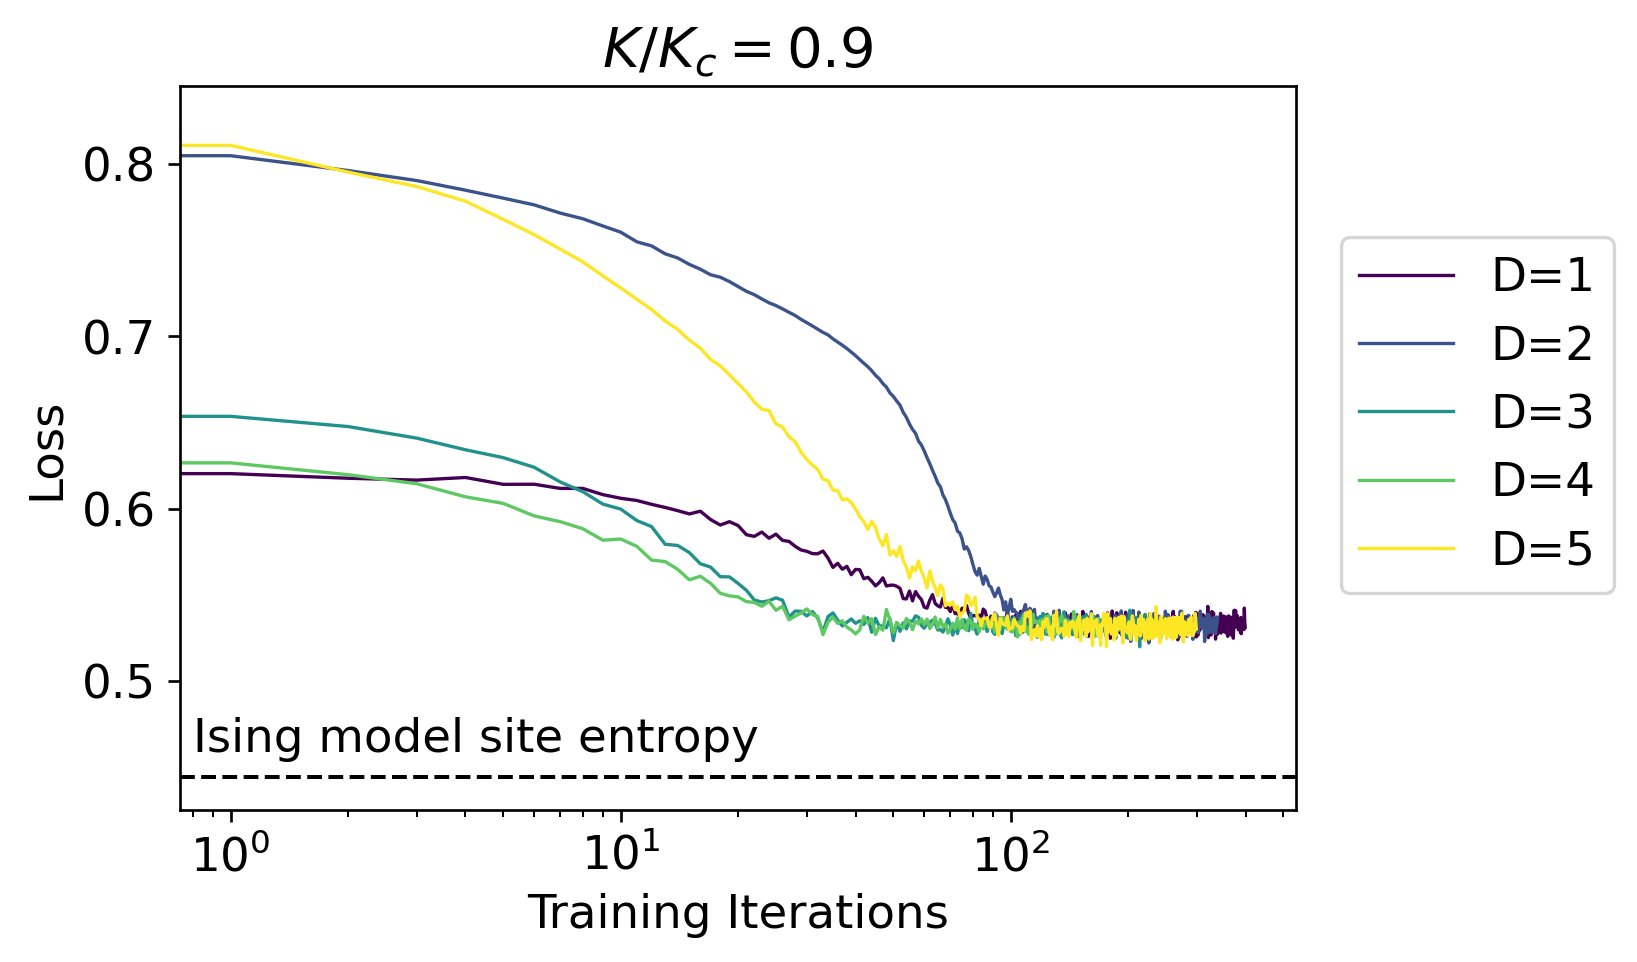

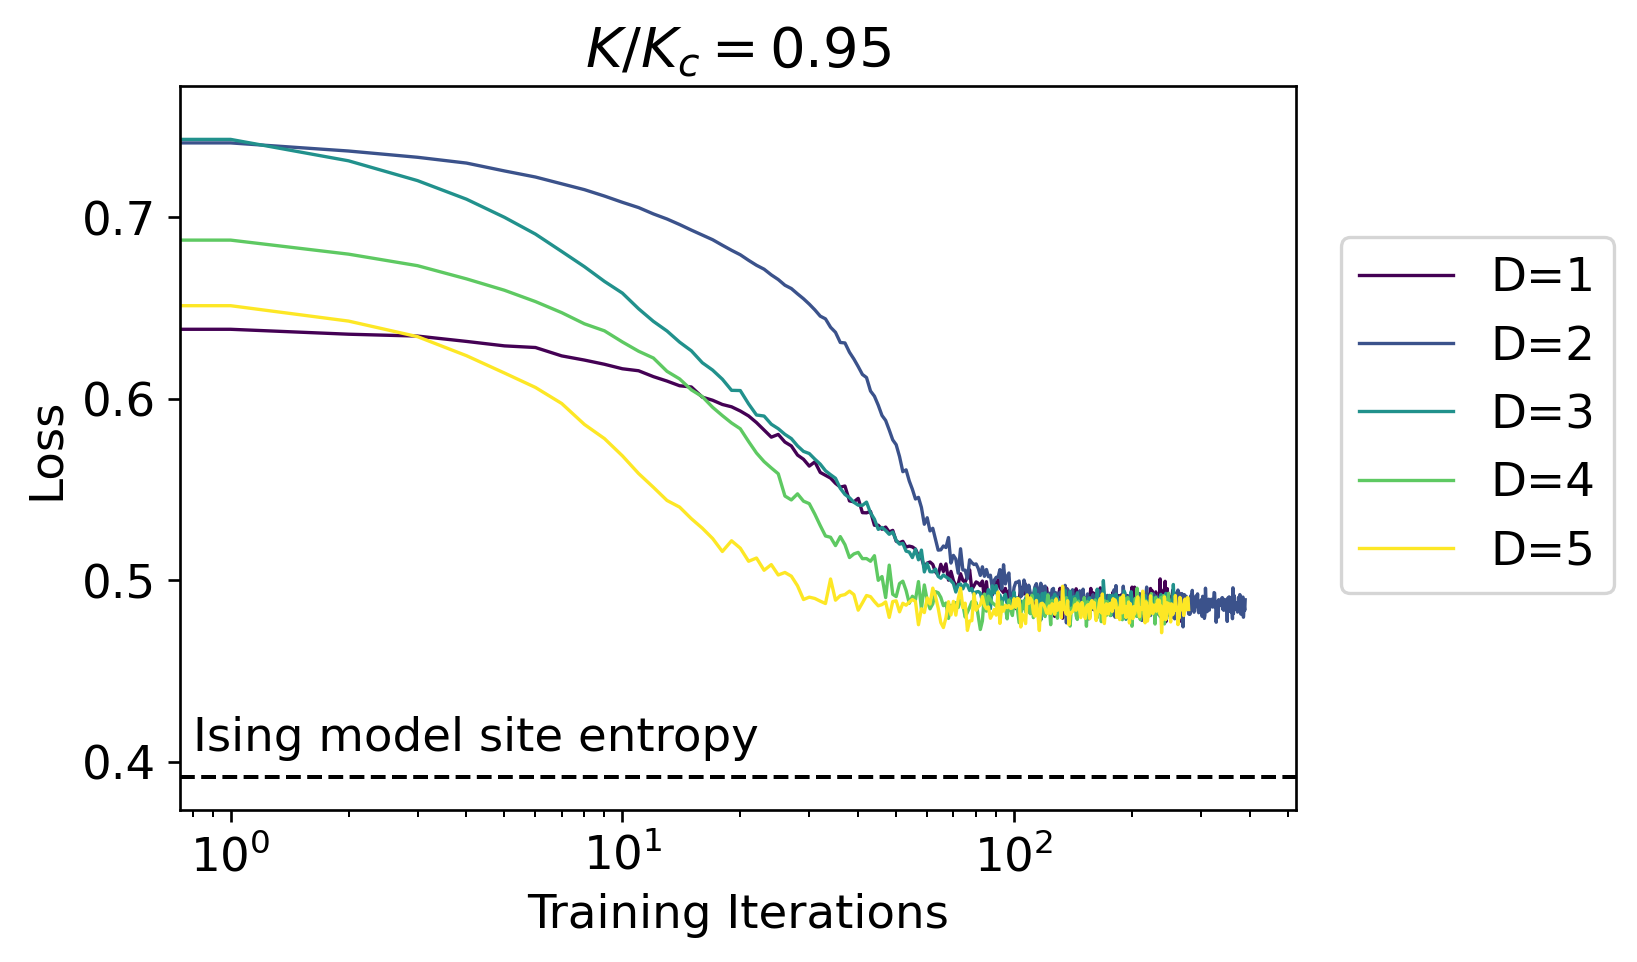

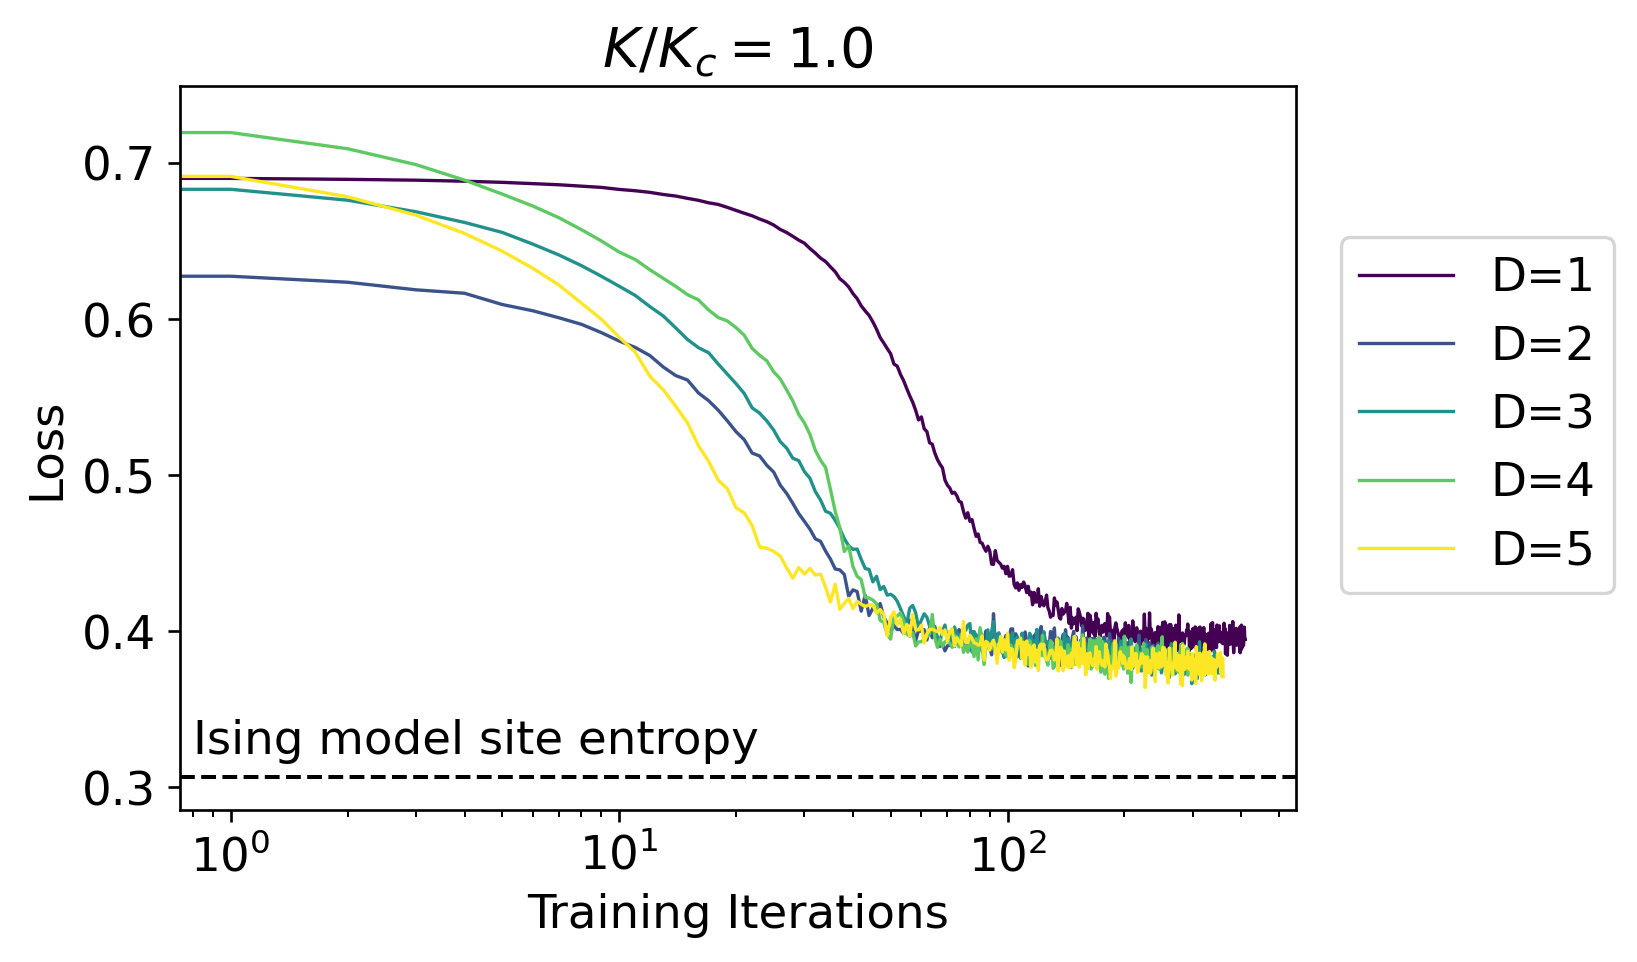

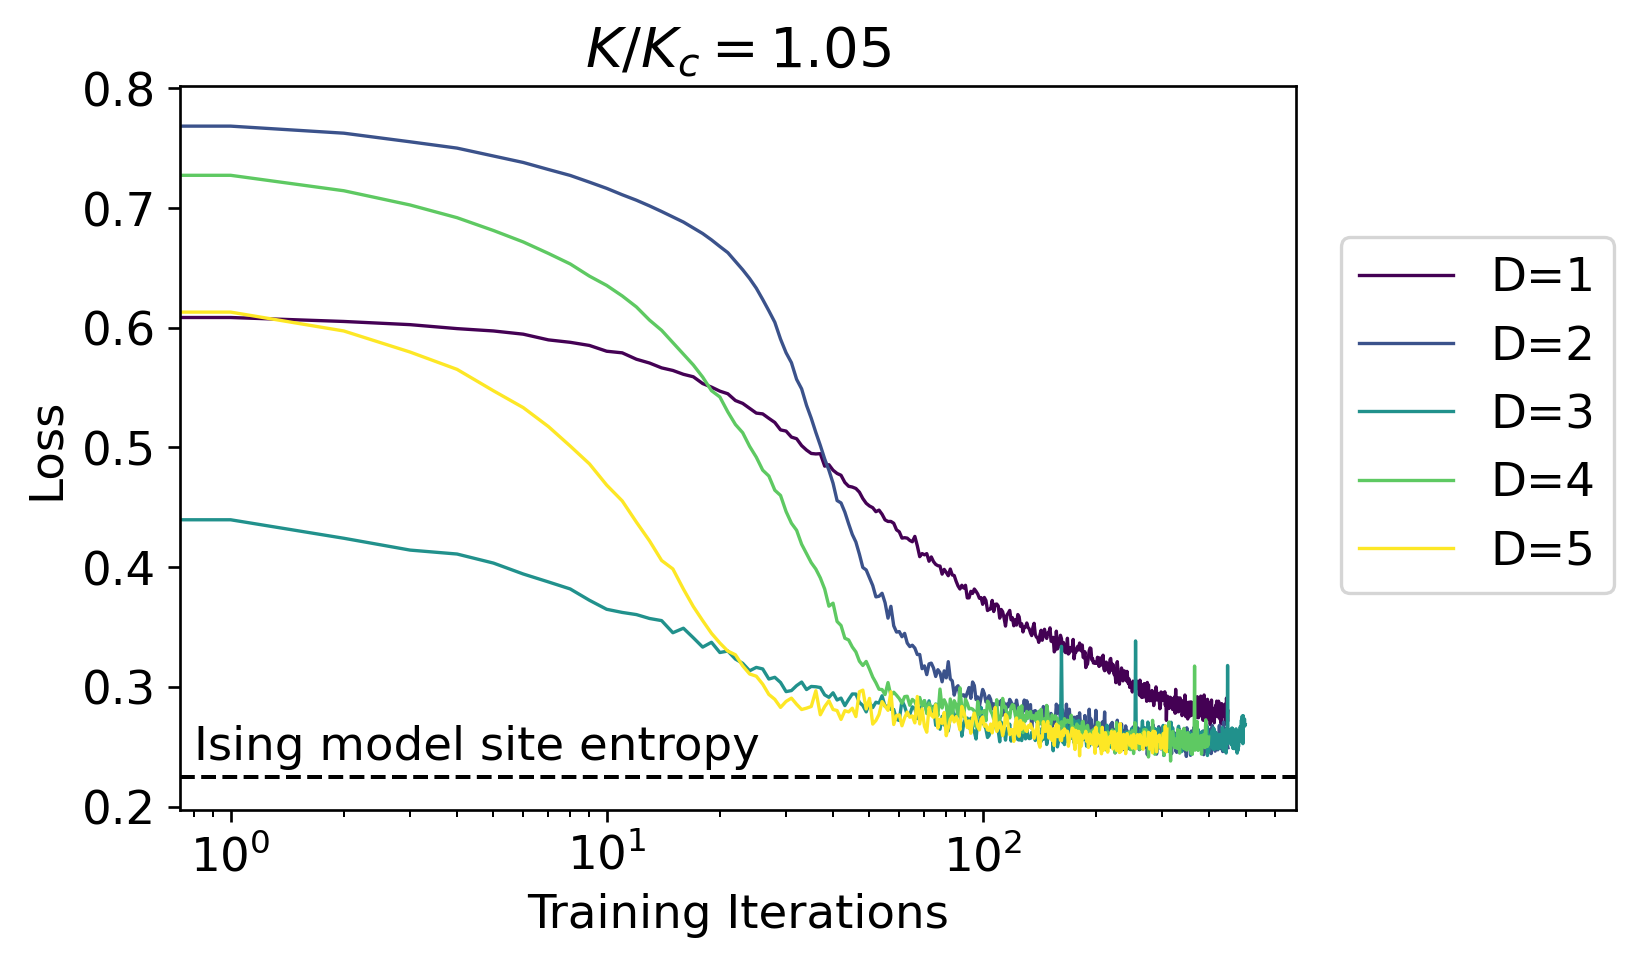

In [304]:
data_dir = os.path.join(DATA_DIR, "2D")
search_term = "adroit_kfrac*"
rfl = glob.glob(os.path.join(data_dir, search_term))
kfrac_list = ['0.9', '0.95', '1.0', '1.05']

cmap = mpl.cm.get_cmap(name="viridis", lut=5)
kfrac_dict = {}
for f in rfl:
    kfrac = get_kfrac(f)
    kfrac_dict[kfrac] = f

for kfrac in kfrac_list:
    f = kfrac_dict[kfrac]
    entropy = get_entropy(dimension=2, interaction_K=[float(kfrac)*INTERACTION_Kc, 0., 0.])
    fig = plt.figure()
    fig.set_size_inches(6,4)
#    fig.set_dpi(300)
    ax = fig.add_subplot(111)
    ax.set_title(f"$K/K_c={kfrac}$")
    ax.set_xlabel("Training Iterations")
    ax.set_ylabel("Loss")
    ax.set_xscale("log")
    ax.axhline(y=entropy, linewidth = 1.2, linestyle="--", color="k")
    ax.text(0.8, entropy+0.015, r"Ising model site entropy")
    for h in np.arange(5)+1:
        ckpt_dir = os.path.join(f, f"hidden_size={h}/version_0/checkpoints")
        ckpts, = os.listdir(ckpt_dir)
        ckpt = os.path.join(ckpt_dir, ckpts)

        model = IsingRNN_simple.load_from_checkpoint(ckpt)
        ax.plot(model.loss_history, label=f"D={h}", c=cmap.colors[h-1], linewidth=1)
    plt.legend(loc=(1.04,0.3))
    plt.show()

In [17]:
kfrac

'0.93'